# Assignment 2: Milestone I Natural Language Processing
## Task 2&3
#### Group DS_G3
#### Members:  
*   To Minh Tuan  s4055570
*   Huynh Huu Tri s4079860
*   Tran Viet Duc s4106117
*   Tran Minh Quang s4098857






Environment: Python 3 and Jupyter notebook

Libraries used: please include all the libraries you used in your assignment, e.g.,:
```
import gensim.downloader as api
from gensim.models import FastText
import lightgbm as lgb
from matplotlib import pyplot as plt
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, RegexpTokenizer
import numpy as np
import os
import pandas as pd
import re
from scipy.sparse import hstack, csr_matrix
from scipy.stats import chi2_contingency
import seaborn as sns
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, make_scorer, classification_report
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, StandardScaler
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import warnings
```
## 1. Introduction

This notebook implements Tasks 2 and 3 of the NLP pipeline for clothing review analysis and classification. Building on the text preprocessing work completed in Task 1, we first generate multiple feature representations of customer reviews using both traditional bag-of-words and modern word embedding approaches. Specifically, we compute count vectors through a bag-of-words model and develop unweighted and TF-IDF weighted document vectors using FastText embeddings to capture semantic relationships between words. We then build and evaluate several machine learning models (Logistic Regression, SVM, and gradient boosting classifiers) that predict whether customers recommend products based on their reviews. This comprehensive approach allows us to identify the most effective text representation and classification methods for the customer review prediction task.

### 1.1. Table of content

The outline of this Notebook "task2_3.ipynb" is described as below:

1. Introduction

    1.1. Table of content

    1.2. Importing libraries

2. Task 2 - Generating Feature Representations for Clothing Items Reviews

    2.1. Compute count vectors with Bag-of-words model

    2.2. Compute unweighted and weighted vectors with Word Embeddings model

    2.3. Compute all 3 types of document vector based on both models

    2.4. Saving outputs

3. Task 3 - Clothing Review Classification

    3.1. Dataset statistical discovery

    3.2. Set up model trainning

    3.3. Training Machine Learning (ML) Model

4. Conclusion
5. References

### 1.2. Importing libraries

In [1]:
# install gensim if the package is not existed -- MAY NEED TO RESTART KERNEL AFTER INSTALLATION FOR GENSIM TO WORK
!pip install gensim
!pip install lightgbm

In [3]:
# Code to import libraries ??? FIX ME: remove all unused libs before submission
from bs4 import BeautifulSoup
import difflib
import html
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures, TrigramAssocMeasures, TrigramCollocationFinder, QuadgramCollocationFinder, QuadgramAssocMeasures
from nltk.probability import *
from nltk.util import ngrams
from sklearn.base import BaseEstimator, TransformerMixin
from collections import Counter
import gensim.downloader as api
from gensim.models import FastText
import joblib
import lightgbm as lgb
from matplotlib import pyplot as plt
import nltk
from nltk.corpus import words, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, RegexpTokenizer
import numpy as np
import os
import pandas as pd
import re
from scipy.sparse import hstack, csr_matrix
from scipy.stats import chi2_contingency
import seaborn as sns
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, make_scorer, classification_report
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, StandardScaler
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import warnings

from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

# load default dataset
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Code to import libraries ??? FIX ME: remove all unused libs before submission

# load default dataset
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('words')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')
nltk.download('averaged_perceptron_tagger_eng') # Add this line to download the missing resource

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\tomin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tomin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\tomin\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\tomin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tomin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\tomin\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]    

True

## 2. Task 2 - Generating Feature Representations for Clothing Items Reviews

The vocabulary of each attribute is stored in Python dictionary (`dict()`), of which the keys are unique tokens, and the values are the id of each token (in alphabetical order).
+ `vocab_title`: Store the vocabulary of <b>*Title*</b> after text preprocessing pipeline.
+ `vocab_text`: Store the vocabulary of <b>*Review Text*</b> after text preprocessing pipeline.
+ `vocab_both`: Store the vocabulary of <b>*Title And Review*</b> after text preprocessing pipeline.

In [4]:
# Function to read vocabulary file to a Python dict()
def read_vocab(filename):
  vocab = {}
  with open(filename, 'r') as f:
    vocab = {line.split(':')[0]: int(line.split(':')[1]) for line in f} # Convert index to integer
  return vocab

In [4]:
# read cleaned dataset and vocabularies of text attributes
df = pd.read_csv('processed_234.csv') # cleaned dataset
vocab_title = read_vocab('vocab_title_234.txt') # vocab of 'Title' attribute
vocab_text = read_vocab('vocab_text_234.txt') # vocab of 'Review Text attribute
vocab_both = read_vocab('vocab_both_234.txt') # vocab of 'Title And Review' attribute

# Fill NaN values in the relevant text columns with empty strings before splitting
df[['Title', 'Review Text', 'Title And Review']].fillna('', inplace = True)
display(df.head())

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Title And Review
0,0,1077,60,major design flaw,had-such-high-hopes work initially petite usua...,3,0,0,General,Dresses,Dresses,major design flaw had-such-high-hopes work ini...
1,1,1049,50,favorite buy,jumpsuit fun flirty fabulous time compliment,5,1,0,General Petite,Bottoms,Pants,favorite buy jumpsuit fun flirty fabulous time...
2,2,847,47,shirt,shirt due adjustable front tie length legging ...,5,1,6,General,Tops,Blouses,shirt shirt due adjustable front tie length le...
3,3,1080,49,petite,tracy-reese dress petite foot tall brand prett...,2,0,4,General,Dresses,Dresses,petite tracy-reese dress petite foot tall bran...
4,4,858,39,shimmer fun,basket hte person store pick teh darker pale h...,5,1,1,General Petite,Tops,Knits,shimmer fun basket hte person store pick teh d...


### 2.1. Compute count vectors with Bag-of-words model
This section defines a function `calc_BOW_model()` to calculate count vectors (document representation) for a text column in the dataset.

This function will be used to implement Bag-of-words model on text attributes later.

In [5]:
# Function to calculate Bag-of-words model
def calc_count_vectors(df, attribute: str, vocab_dict: dict):
  '''
    Args:
      df: Dataset used
      attribute: The column of the dataset that contains text to be processed
      vocab_dict: The vocabulary with ids of tokens
    Returns:
      count_matrix: document representation for the df[attribute] based on Bag-of-word model (sparse matrix, count_matrix[i, j] count how many word j found in document i)
  '''
  # ---- Calculate Count Vectors ----
  vectorizer = CountVectorizer(analyzer = 'word', vocabulary = vocab_dict) # define vocabulary dict
  count_matrix = vectorizer.fit_transform(df[attribute].fillna('')) # calculate count vectors

  return count_matrix

### 2.2. Compute unweighted and weighted vectors with Word Embeddings model
This section choose a word embeddings model to compute unweighted and weighted vectors (document representation).

The code below download a pre-trained word embedding model, to prepare for generating weighted and unweighted vectors later. The model downloading may consume times, thus it is separated in a distinct code cell.

#### 2.2.1. Download FastText model

When analyzing clothing reviews for classification purposes, the choice of word embedding model is crucial for capturing semantic meaning and handling domain-specific terminology.

Çano and Morisio (2019) studies shows FastText performed best for sentiment classification tasks, particularly with domain-specific vocabulary.

**FastText Advantages for Clothing Review Data**

| Advantage                         | Explanation                                                                                                                                                                                                                                                                   |
|-----------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Out-of-Vocabulary (OOV) Handling** | Fashion terminology includes brand names, product styles, and design elements that may be rare or absent from training data. FastText represents words as bags of character n-grams rather than atomic units (Bojanowski et al., 2017), enabling embeddings for unseen or creative words (e.g., *super-comfy*, *dress-like*). |
| **Sematic Richness**        | Clothing reviews often contain variations (e.g., *flowy*, *flowiness*) and collocations (*lightweight*, *well-made*). FastText leverages subword structures, outperforming Word2Vec in morphologically rich contexts (Mikolov et al., 2018).                                    |
| **Handling of Small Datasets**    | The dataset has ~7,000 unique tokens across 20,000 reviews. FastText generalizes better on small training data compared to models treating words as atomic units due to its character n-gram approach (Bojanowski et al., 2017).                                               |
| **Processing Efficiency**         | FastText provides computational efficiency suitable for this dataset size. Joulin et al. (2016) demonstrated that it trains orders of magnitude faster than deep learning approaches while achieving comparable performance.                                                     |



**Compararison Analysis with Alternative Models**

| Model                          | Strengths                                                                                           | Limitations                                                                                                                                                                                |
|--------------------------------|----------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Word2Vec (Skip-gram/CBOW)**  | Computationally efficient (Mikolov et al., 2013).                                                   | Cannot handle OOV words, which is critical in clothing reviews. Treats words as atomic units, missing morphological links (e.g., *shirt* vs. *shirts*, *comfort* vs. *comfortable*).          |
| **GloVe**                      | Captures global corpus statistics via co-occurrence matrices (Pennington et al., 2014).             | Cannot handle unseen words. Requires larger corpora to perform well.                                                                     |
| **BERT/Transformers**          | Provides contextual embeddings with advanced performance (Devlin et al., 2019).             | Therefore, Computationally highly resource-consuming. Benefits are strongest in complex tasks (Rogers et al., 2020).                             |
| **ELMo**                       | Generates contextual embeddings capturing nuanced term usage (Peters et al., 2018).                 | Computationally intensive. Likely excessive for binary classification tasks where recommendation intent is explicit.                                                                         |

There are 3 Fast Text models trained:
+ `fasttext_title_model`: Fast Text pretrained model applied transfer learning with *Title*.
+ `fasttext_text_model`: Fast Text pretrained model applied transfer learning with *Review Text*.
+ `fasttext_both_model`: Fast Text pretrained model applied transfer learning with *Title And Review*.

In [6]:
def train_fasttext_model(df, attribute):
  '''
    Train FastText model on corpus
    Args:
      df (pd.DataFrame): Dataset used
      attribute (str): The column of the dataset that contains text to be processed
    Returns:
      model: The trained FastText model
  '''
  print(f"Training FastText model for {attribute}:", end = ' ')

  # Ensure the column has no NaN values before splitting
  corpus = list(df[attribute].fillna('').str.split(' ')) # tokenization

  model = FastText(
    sentences = corpus,
    vector_size = 100,
    window = 5,
    min_count = 1,
    epochs = 10,
    workers = 4,
    sg = 1,
    seed = 42
  )
  print(f"{len(model.wv.key_to_index):,} vocab, {model.wv.vector_size}D vectors")
  return model

fasttext_text_model = train_fasttext_model(df, 'Review Text')
fasttext_title_model = train_fasttext_model(df, 'Title')
fasttext_both_model = train_fasttext_model(df, 'Title And Review')

Training FastText model for Review Text: 6,363 vocab, 100D vectors
Training FastText model for Title: 1,478 vocab, 100D vectors
Training FastText model for Title And Review: 6,659 vocab, 100D vectors


#### 2.2.2. Compute unweighted and weighted vectors
This section defines 2 functions:
+ `calc_unwweighted_vectors(df, attribute, model)`: Calculate unweighted vectors (2D numpy dense array) based on `df[attribute]` data, using embeding model `model`.
+ `calc_weighted_vectors(df, attribute, model)`: Calculate weighted vectors (2D numpy dense array) based on `df[attribute]` data, using embeding model `model`.

In [7]:
# Function to calculate unweighted vectors (document representation) based on an embedding model loaded in advance
def calc_unweighted_vectors(df, attribute, model):
  '''
  Calculates unweighted document vectors by taking the simple mean of word vectors.

  Args:
    df: The DataFrame containing the text data.
    attribute: The column name in the DataFrame with the text.
    model: The pre-trained word embedding model (e.g., Word2Vec, FastText).

  Returns:
    numpy.ndarray: A 2D array where each row is the unweighted vector for a document.
  '''
  # Calculate corpus by splitting the text into tokens
  corpus = list(df[attribute].str.split(' ')) # tokenization

  # Compute Unweighted Review Vectors (simple mean)
  unweighted_vectors = []
  for tokens in corpus:
    # Handle cases where tokens is not a list (e.g., NaN values that became floats)
    if not isinstance(tokens, list) or not tokens:  # Handle empty documents or non-list entries
      zero_vector = np.zeros(model.wv.vector_size)
      unweighted_vectors.append(zero_vector)
      continue

    # Get word vectors for tokens present in the model's vocabulary
    vectors = [model.wv[token] for token in tokens if token in model.wv.key_to_index]

    # If no tokens are found in the model, append a zero vector
    if not vectors:
      unweighted_vectors.append(np.zeros(model.wv.vector_size))
      continue

    # Calculate and append the mean vector
    unweighted_vectors.append(np.mean(vectors, axis=0))

  return np.vstack(unweighted_vectors)  # shape: (n_docs, vector_size)

In [8]:
# Function to calculate weighted vectors (document representation) based on an embedding model loaded in advance
def calc_weighted_vectors(df, attribute, vocab_dict, model, tfidf_vectorizer = None):
  '''
  Calculates TF-IDF weighted document vectors.

  Args:
    df: The DataFrame containing the text data.
    attribute: The column name in the DataFrame with the text.
    vocab_dict: A dictionary mapping vocabulary tokens to their unique IDs.
    model: The pre-trained word embedding model (e.g., Word2Vec, FastText).

  Returns:
    numpy.ndarray: A 2D array where each row is the weighted vector for a document.
  '''
  # Use TfidfVectorizer with the predefined vocabulary to get TF-IDF scores
  if tfidf_vectorizer is None:
    tfidf_vectorizer = TfidfVectorizer(analyzer = 'word', vocabulary = vocab_dict, lowercase = True)
    tfidf_matrix = tfidf_vectorizer.fit_transform(df[attribute].fillna('')) # Fill NaN values with empty strings before vectorization
  else:
    tfidf_matrix = tfidf_vectorizer.transform(df[attribute].fillna(''))

  # Precompute embedding matrix aligned with vocab_dict
  embedding_matrix = np.zeros((len(vocab_dict), model.wv.vector_size))
  for token, idx in vocab_dict.items():
    if token in model.wv.key_to_index:  # Check if token exists in pretrained model
      embedding_matrix[idx] = model.wv[token]
    # else remains zero vector

  # Compute Weighted Review Vectors (TF-IDF weighted mean)
  weighted_vectors = []
  for doc_idx in range(tfidf_matrix.shape[0]):
    row = tfidf_matrix.getrow(doc_idx)
    indices = row.indices # only get element that is not = 0
    weights = row.data

    if len(indices) == 0:
      weighted_vectors.append(np.zeros(model.wv.vector_size))
      continue

    # Get the corresponding word vectors from the precomputed embedding matrix
    word_vecs = embedding_matrix[indices]

    # Perform a dot product to get the weighted sum
    weighted_sum = np.dot(weights, word_vecs)
    weighted_avg = weighted_sum / weights.sum()
    weighted_vectors.append(weighted_avg)

  return np.vstack(weighted_vectors)  # shape: (n_docs, vector_size)

### 2.3. Compute all 3 types of document vector based on both models
This section defines `calc_vectors(df, atrtibute, vocab_dict, model)` function to calculate document representation in form of:
+ <b>Count vectors:</b> Generated from `df[attribute]`, with its vocabulary `vocab_dict`.
+ <b>Unweighted vectors:</b> Generated from `df[attribute]`, with its vocabulary `vocab_dict`, using embedding model `model`.
+ <b>Weighted vectors:</b> Generated from `df[attribute]`, with its vocabulary `vocab_dict`, using embedding model `model`.

In [9]:
# Function to calculate 3 vectors at the same time: BOW model (count vectors), embedding models (weighted vectors and unweighted vectors)
def calc_vectors(df, attribute, vocab_dict, model):
  '''
    Args:
      df: Dataset used
      vocab_dict: The vocabulary with ids of tokens
    Returns:
      count_matrix: count vectors for Bag-of-word model or not
      unweighted_vectors: unweighted vectors for embedding model predefined in `model` or not
      weighted_vectors: weighted vectors for embedding model predefined in `model` or not
  '''
  if model == '':
    model = train_fasttext_model(df, attribute)

  count_vectors = calc_count_vectors(df, attribute, vocab_dict) # Bag-of-words model
  unweighted_vectors = calc_unweighted_vectors(df, attribute, model) # FastText model generate unweighted document vectors
  weighted_vectors = calc_weighted_vectors(df, attribute, vocab_dict, model) # # FastText model generate weighted document vectors

  return count_vectors, unweighted_vectors, weighted_vectors

### 2.4. Saving outputs
This section save the document representation in 3 files:
+ "count_vectors.txt": store Count Vectors.
+ "unweighted_vectors.txt": store Unweighted Vectors.
+ "weighted_vectors.txt": store Weighted Vectors.

In [10]:
def save_vectors(vectors, filename, is_sparse=False):
  """Save vectors in tutor's required format"""

  with open(filename, 'w', encoding='utf-8') as f:
    for doc_idx, vector_data in enumerate(vectors):
      if is_sparse: # vectors is sparse vector
        sparse_items = [f"{word_idx}:{freq}" for word_idx, freq in sorted(zip(vector_data.indices, vector_data.data))]
        line = f"#{doc_idx},{','.join(sparse_items)}\n"
      else: # vector is dense vector
        vector_str = ','.join([f"{val:.6f}" for val in vector_data])
        line = f"#{doc_idx},{vector_str}\n"
      f.write(line)

  print(f"Finish save {filename}")

# Generate all vector representations
count_vectors, unweighted_vectors, weighted_vectors = calc_vectors(df, 'Review Text', vocab_text, fasttext_text_model)

# Save in required format
save_vectors(count_vectors, 'count_vectors.txt', is_sparse = True)
save_vectors(unweighted_vectors, 'unweighted_vectors.txt')
save_vectors(weighted_vectors, 'weighted_vectors.txt')

Finish save count_vectors.txt
Finish save unweighted_vectors.txt
Finish save weighted_vectors.txt


## 3. Task 3 - Clothing Review Classification

This section discover the dataset, build Machine Learning (ML) models to predict the attribute *Recommended IND*, and compare models based on their performances.

### 3.1. Dataset statistical discovery
This section discover the dataset using statistical strategies like correlation, cohesion, data distribution.

#### 3.1.1. Correlation and causation

This section discover relationship between attributes, especially the relationship of independent attributes with the target attribute (*Recommended IND*).

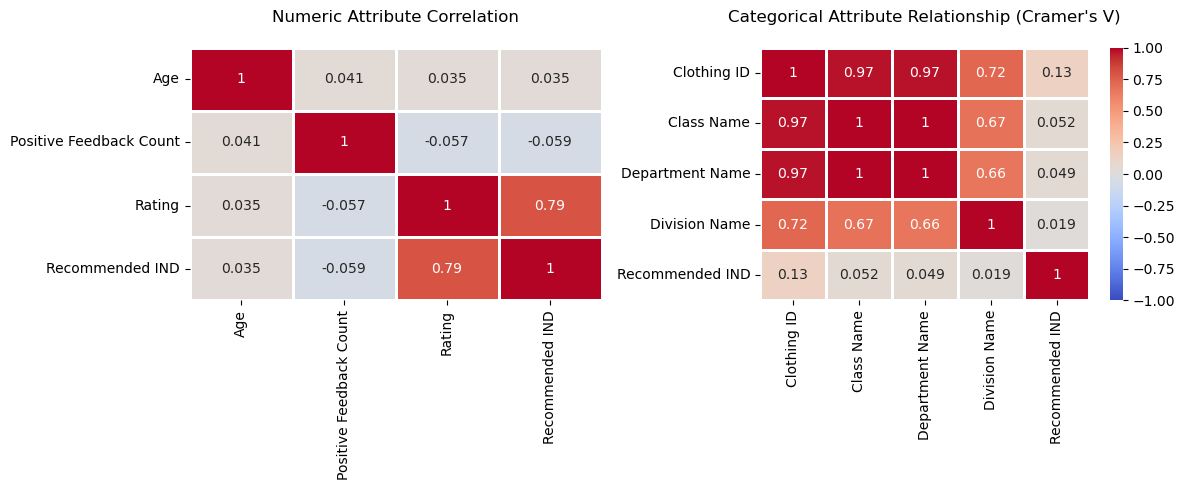

In [11]:
# visualization for attributes relationship

fig, axes = plt.subplots(1, 2, figsize = (12, 5)) # set up outline for plot visualization

# ---- Visualize correlation between numeric attributes ----
corr = df[['Age', 'Positive Feedback Count', 'Rating', 'Recommended IND']].corr()
sns.heatmap(corr, annot = True, ax = axes[0], cbar = False,
            cmap = "coolwarm", vmin = -1, vmax = 1, center = 0, linecolor = 'white', linewidths = 1)
axes[0].set_title('Numeric Attribute Correlation\n')

# ---- Visualize relationship between categorical attributes ----
# using Chi-squared test of independence

def cramers_v(x, y): # Calculate Cramer's V for two categorical variables
  contingency_table = pd.crosstab(x, y)
  chi2 = chi2_contingency(contingency_table)[0]
  n = contingency_table.sum().sum()
  phi2 = chi2 / n
  r, k = contingency_table.shape
  phi2_corrected = max(0, phi2 - ((k-1)*(r-1))/(n-1))
  r_corrected = r - ((r-1)**2)/(n-1)
  k_corrected = k - ((k-1)**2)/(n-1)
  return np.sqrt(phi2_corrected / min( (k_corrected-1), (r_corrected-1)))

# set up columns to analyze and matrix to store relationship score
columns = ['Clothing ID', 'Class Name', 'Department Name', 'Division Name', 'Recommended IND'] # Categorical attributes to analyze
v_matrix = np.identity(len(columns)) # Initialize with 1 on diagonal

# calculate relationship score
for i in range(len(columns)):
  for j in range(i + 1, len(columns)):
    v_value = cramers_v(df[columns[i]], df[columns[j]]) # Calculate Cramer's V for the pair of columns
    v_matrix[i, j] = v_value
    v_matrix[j, i] = v_value

# visualize v_matrix with heatmap
sns.heatmap(v_matrix, annot = True, ax = axes[1],
            cmap = 'coolwarm', vmin=-1, vmax=1, center=0, linecolor = 'white', linewidths = 1, xticklabels = columns, yticklabels = columns)
axes[1].set_title('Categorical Attribute Relationship (Cramer\'s V)\n')

plt.tight_layout()

> Based on the heat map above, 2 insights can be concluded:
> 1. *Rating* is a good predictor.
> 2. *Clothing ID*, *Department Name* should not be used as predictors.

Those insights can be proved as below:

<b>1. Rating is a good predictor </b>

Based on the heat map above, *Rating* has really strong relationship with the target *Recommended IND* (around 0.79 out of 1). There are 2 possibilities can occur:
1. *Rating* provide strong information for model to predit *Recommended IND*.
2. *Rating* leak information for the *Recommended IND*, which is not good in trainning Machine Learning model.

The second posibility occurs when *Rating* is computed by the target *Recommended IND*. However, in the Metadata description, there is no sign that *Rating* is infered from *Recommended IND*:
+ *Rating* description: Positive Ordinal Integer variable for the product score granted by the customer from 1 (worst) to 5 (best).
+ *Recommended IND* description: Binary indicator representing whether the customer recommend ('1') the clothing item or not ('0').

Therefore, those 2 variables may independently gathered.

Moreover, the correlation score of those variables are not extremely high (like higher than 0.8 or 1), there are still many records showing high rating without being recommended by customers (view the count plot below). The work of infering exact *Recommended IND* based on *Rating* is impossible, therefore, their strong correlation should not be considered as a sign of Data Leakage.

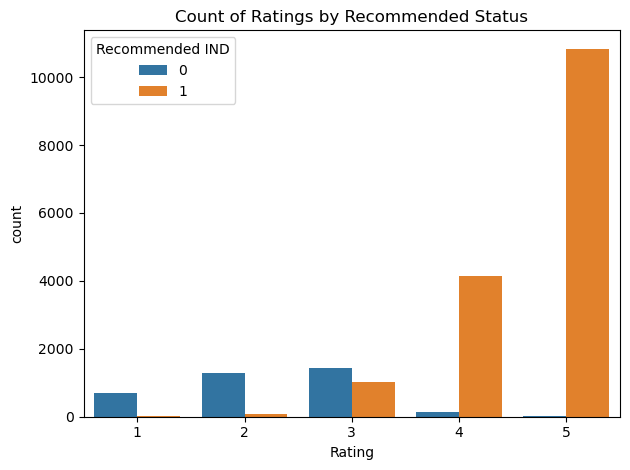

In [12]:
# Create the countplot and store the Axes object
ax = sns.countplot(data = df, x = 'Rating', hue = 'Recommended IND')
ax.set_title('Count of Ratings by Recommended Status')
plt.tight_layout()

<b>2. *Clothing ID*, *Department Name* should not be used as predictors.</b>

Based on the heatmaps above, *Clothing ID*, *Class Name*, *Department Name* are predictors having very strong relationship (around 0.97).

In [13]:
# Check whether we can infer 'Class Name', 'Department Name' based on 'Clothing ID' or not
# Idea: If each Clothing ID belongs to only 1 Class or Department, we can infer the Class (or Department) based on that Clothing ID
def validate_relationships(df, child_attribute, parent_attribute):
  check = df.groupby(child_attribute)[parent_attribute].nunique() # group by child_attribute and count unique parent_attribute
  if (check <= 1).all(): # if all child_attribute has at most 1 parent_attribute -> pass, else -> fail
      print(f"Each '{child_attribute}' belongs to exactly one '{parent_attribute}'.")
  else:
      # Find the IDs that fail the test
      problem_ids = check[check > 1].index.tolist()
      print(f"Some '{child_attribute}' belong to more than one '{parent_attribute}': {problem_ids}")

validate_relationships(df, 'Clothing ID', 'Class Name')
validate_relationships(df, 'Clothing ID', 'Department Name')
validate_relationships(df, 'Class Name', 'Department Name')

Some 'Clothing ID' belong to more than one 'Class Name': [1119]
Each 'Clothing ID' belongs to exactly one 'Department Name'.
Each 'Class Name' belongs to exactly one 'Department Name'.


The test above show that we can even infer exactly *Department Name*, or *Class Name* (just 1 case fail) based on *Clothing ID*.

*Clothing ID*, *Class Name*, *Department Name* are predictors. Their strong relationship is redundant and can be considered as multicollinearity problem. It increase the size of dataset without useful information for models to learn, causing unstable coefficients and difficulty in interpreting the model. Therefore, only 1 attribute should be kept.

* <b>*Clothing ID* should not be kept:</b>

*Clothing ID* provide most insights for model training since it is the most detailed variable. However, lots of Clothing IDs only occur 1 time in the dataset (448 out of 1095 clothing ids, view the code below). Those rare Clothing IDs may be meaningless in prediction and may cause overfiting.

In [14]:
# show Clothing ID appear `num_occurance` time in df
num_occurance = 1
clothing_id_counts = df['Clothing ID'].value_counts()
clothing_ids_with_specific_count = clothing_id_counts[clothing_id_counts <= num_occurance]
print(f"{len(clothing_ids_with_specific_count)} out of {len(clothing_id_counts)} clothing ids appear {num_occurance} times")
clothing_ids_with_specific_count.head()

448 out of 1095 clothing ids appear 1 times


Clothing ID
43     1
353    1
321    1
559    1
192    1
Name: count, dtype: int64

* <b>*Class Name* should be kept rather than *Department Name*</b>

There are only 6 unique *Department Name*, which is too general for model to learn, classify and predict. The *Class Name* variable with 20 unique values may be more detailed and may support the model classify better.

In [15]:
print(f"Unique Department Names: {df['Department Name'].unique()}")
print(f"Unique Class Names: {df['Class Name'].unique()}")

Unique Department Names: ['Dresses' 'Bottoms' 'Tops' 'Intimate' 'Jackets' 'Trend']
Unique Class Names: ['Dresses' 'Pants' 'Blouses' 'Knits' 'Intimates' 'Outerwear' 'Lounge'
 'Sweaters' 'Skirts' 'Fine gauge' 'Sleep' 'Jackets' 'Swim' 'Trend' 'Jeans'
 'Shorts' 'Legwear' 'Layering' 'Casual bottoms' 'Chemises']


In conclusion, *Clothing ID* and *Department Name* should be eliminated, since they are too detailed and too general respectively, and cause multicollinearity issue (have strong relationship with *Class Name*).

In [16]:
# Function to drop dependent attributes
def drop_columns(df, columns):
  result_df = df.drop(columns = columns)
  return result_df

print("*** Demo drop columns to test function ***")
drop_columns(df, ['Clothing ID', 'Department Name']).head()

*** Demo drop columns to test function ***


,Unnamed: 0,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Class Name,Title And Review
0,0,60,major design flaw,had-such-high-hopes work initially petite usua...,3,0,0,General,Dresses,major design flaw had-such-high-hopes work ini...
1,1,50,favorite buy,jumpsuit fun flirty fabulous time compliment,5,1,0,General Petite,Pants,favorite buy jumpsuit fun flirty fabulous time...
2,2,47,shirt,shirt due adjustable front tie length legging ...,5,1,6,General,Blouses,shirt shirt due adjustable front tie length le...
3,3,49,petite,tracy-reese dress petite foot tall brand prett...,2,0,4,General,Dresses,petite tracy-reese dress petite foot tall bran...
4,4,39,shimmer fun,basket hte person store pick teh darker pale h...,5,1,1,General Petite,Knits,shimmer fun basket hte person store pick teh d...


#### 3.1.2. Data distribution
Skewed distribution and different ranges in variables should also be considered.

Despite not affecting tree models (like Decision Tree, Random Forest), those issues can still negatively impact some other models like Logistic Regression. Moreover, scaling ranges of variables can also speed up the convergence process of the some models' loss function.

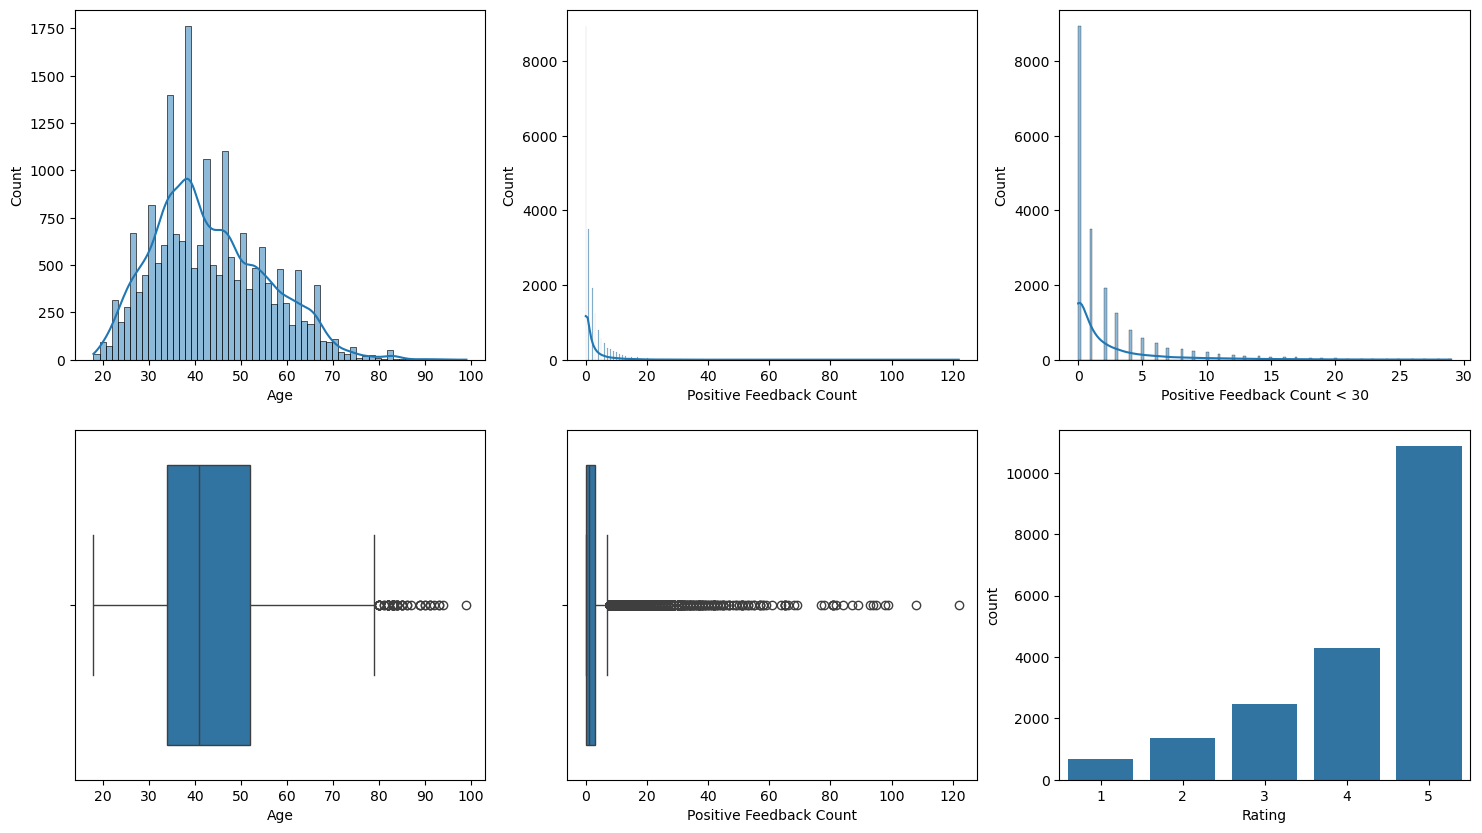

In [17]:
# distribution of numerical attributes

fig, axes = plt.subplots(2, 3, figsize = (18, 10)) # set up outline for plot visualization

for i, col in enumerate(['Age', 'Positive Feedback Count']):
  sns.histplot(data = df, x = col, kde = True, ax = axes[0, i])

sns.histplot(x = df[df['Positive Feedback Count'] < 30]['Positive Feedback Count'], kde = True, ax = axes[0, 2])
axes[0, 2].set_xlabel('Positive Feedback Count < 30')
sns.countplot(data = df, x = 'Rating', ax = axes[1, 2])

for i, col in enumerate(['Age', 'Positive Feedback Count']):
  sns.boxplot(data = df, x = col, ax = axes[1, i])

Based on the histogram above, data distribution of *Age* is slightly right-skewed. Applying sqrt transformation is enough to fix this issue. The *Positive Feedback Count* data distribution is extremely right-skewed, so it should be transformed by a strong method like log1p transformation. Those transformation can not only fix the distribution to normal, but can also scale the data to reduce the effect of extreme high values.

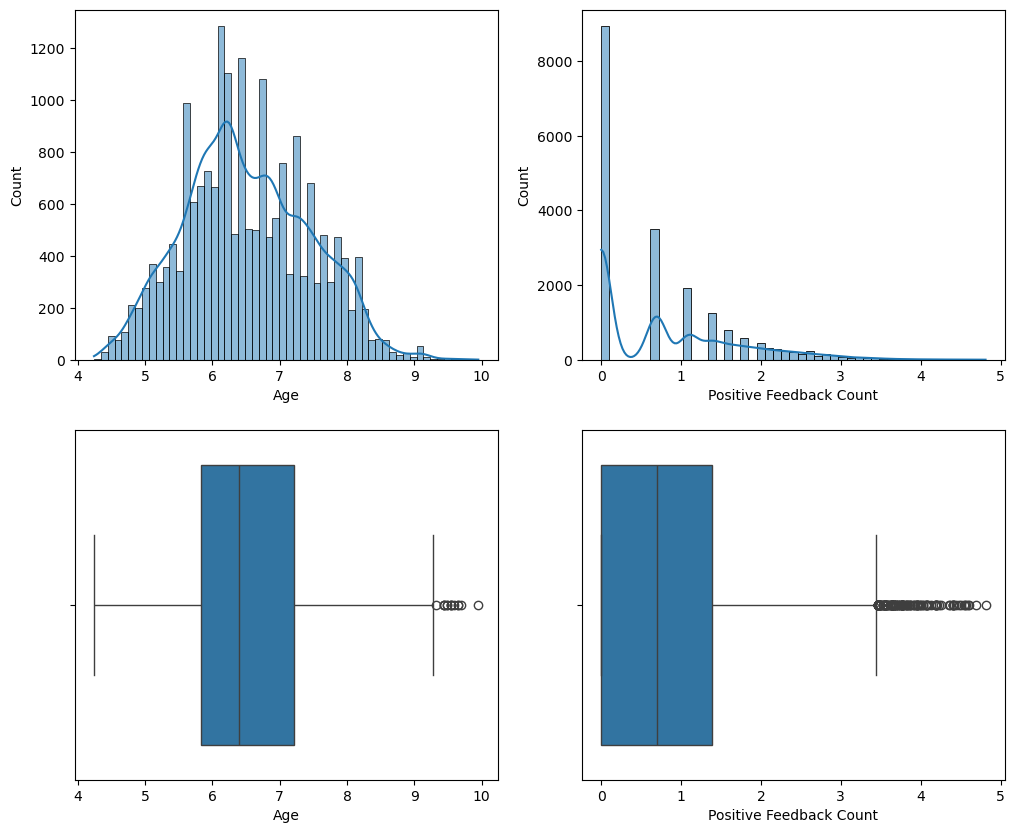

In [18]:
# Function to apply sqrt transform for 'Age' and log transform for 'Positive Feedback Count'
def transform_data(df, columns, methods):
  result_df = df.copy()
  for col, method in zip(columns, methods):
    if method == 'sqrt':
      result_df[col] = np.sqrt(df[col])
    elif method == 'log1p':
      result_df[col] = np.log1p(df[col]) # use log1p (log(value + 1)) to avoid log(0)
  return result_df

df_after_transform = transform_data(df, ['Age', 'Positive Feedback Count'], ['sqrt', 'log1p'])

# visualize again to double check
fig, axes = plt.subplots(2, 2, figsize = (12, 10)) # set up outline for plot visualization

for i, col in enumerate(['Age', 'Positive Feedback Count']):
  sns.histplot(data = df_after_transform, x = col, kde = True, ax = axes[0, i])

for i, col in enumerate(['Age', 'Positive Feedback Count']):
  sns.boxplot(data = df_after_transform, x = col, ax = axes[1, i])

In [19]:
# view data range of numeric attributes
df_after_transform[['Age', 'Rating', 'Recommended IND', 'Positive Feedback Count']].describe()

,Age,Rating,Recommended IND,Positive Feedback Count
count,19662.000000,19662.000000,19662.000000,19662.000000
mean,6.511962,4.183145,0.818177,0.775851
std,0.924769,1.112224,0.385708,0.894548
min,4.242641,1.000000,0.000000,0.000000
25%,5.830952,4.000000,1.000000,0.000000
50%,6.403124,5.000000,1.000000,0.693147
75%,7.211103,5.000000,1.000000,1.386294
max,9.949874,5.000000,1.000000,4.812184


After transformation, the data ranges of all numerical attributes are nearly similar (around the range from 0 to 5, view `df.describe()` in the code above), thus data scaling is unnecessary now.

#### 3.1.3. Categorical attribute handling
Machine learning models cannot directly handle text variables, thus they need to be transformed.

The *Title*, *Review Text*, *Title And Review* are already transformed to numeric variables in advanced. Thus we just need to handle *Class Name* and *Division Name*, which are categorical variables.

In both *Class Name*, *Division Name*, the order of unique values is meaningless (each category is distinct), so they should be transformed with One Hot Encoding.

In [20]:
# Function to apply One Hot encoding for categorical attributes
def onehot_encode(df, columns):
  result_df = df.copy()
  onehot_encoder = OneHotEncoder(drop = 'first', handle_unknown = 'ignore', sparse_output = False)  # drop first to avoid dummy trap
  encoded = onehot_encoder.fit_transform(df[columns])
  encoded_df = pd.DataFrame(encoded, columns = onehot_encoder.get_feature_names_out(columns), index = df.index)
  result_df = pd.concat([df.drop(columns = columns), encoded_df], axis = 1)
  return result_df, onehot_encoder
df_after_transform, onehot_encoder = onehot_encode(df, ['Division Name', 'Class Name'])
df_after_transform.head()


,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Department Name,Title And Review,...,Class Name_Legwear,Class Name_Lounge,Class Name_Outerwear,Class Name_Pants,Class Name_Shorts,Class Name_Skirts,Class Name_Sleep,Class Name_Sweaters,Class Name_Swim,Class Name_Trend
0,0,1077,60,major design flaw,had-such-high-hopes work initially petite usua...,3,0,0,Dresses,major design flaw had-such-high-hopes work ini...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1049,50,favorite buy,jumpsuit fun flirty fabulous time compliment,5,1,0,Bottoms,favorite buy jumpsuit fun flirty fabulous time...,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,847,47,shirt,shirt due adjustable front tie length legging ...,5,1,6,Tops,shirt shirt due adjustable front tie length le...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,1080,49,petite,tracy-reese dress petite foot tall brand prett...,2,0,4,Dresses,petite tracy-reese dress petite foot tall bran...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,858,39,shimmer fun,basket hte person store pick teh darker pale h...,5,1,1,Tops,shimmer fun basket hte person store pick teh d...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
# All process of preparing data
def prepare_data(df):
  '''
    Implement the entire pipeline of preparing data for training model
    Args:
      df (pd.DataFrame): Data Frame to be prepared
    Returns:
      result_df (pd.DataFrame): Prepared Data Frame
      onehot_encoder (sklearn.preprocessing.OneHotEncoder): One Hot Encoder used (for recovery when needed)
  '''
  result_df = df.copy()
  result_df = drop_columns(result_df, ['Clothing ID', 'Department Name']) # drop predictors with high correlations
  result_df = transform_data(result_df, ['Age', 'Positive Feedback Count'], ['sqrt', 'log1p']) # transform & scale data to ensure normal distribution and balanced data ranges
  result_df, onehot_encoder = onehot_encode(result_df, ['Division Name', 'Class Name']) # transform Categorical text data into numeric values
  return result_df, onehot_encoder

df_before_prepare = df.copy() # backup
df, onehot_encoder = prepare_data(df)
df.head()

,Unnamed: 0,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Title And Review,Division Name_General Petite,Division Name_Initmates,...,Class Name_Legwear,Class Name_Lounge,Class Name_Outerwear,Class Name_Pants,Class Name_Shorts,Class Name_Skirts,Class Name_Sleep,Class Name_Sweaters,Class Name_Swim,Class Name_Trend
0,0,7.745967,major design flaw,had-such-high-hopes work initially petite usua...,3,0,0.000000,major design flaw had-such-high-hopes work ini...,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,7.071068,favorite buy,jumpsuit fun flirty fabulous time compliment,5,1,0.000000,favorite buy jumpsuit fun flirty fabulous time...,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,6.855655,shirt,shirt due adjustable front tie length legging ...,5,1,1.945910,shirt shirt due adjustable front tie length le...,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,7.000000,petite,tracy-reese dress petite foot tall brand prett...,2,0,1.609438,petite tracy-reese dress petite foot tall bran...,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,6.244998,shimmer fun,basket hte person store pick teh darker pale h...,5,1,0.693147,shimmer fun basket hte person store pick teh d...,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 3.2. Set up model trainning
This section set up essential things to train and test Machine Learning Model, including:
+ Choose storing metrics and define function to train and test models.
+ Introduce chosen Machine Learning models.

#### 3.2.1. Scoring metrics decision and train test function
This section chooses scoring metrics to evaluate models based on real-life senario and the problems that the model is aimed to tackle (related to business and customers benefits).

<Axes: xlabel='Recommended IND', ylabel='count'>

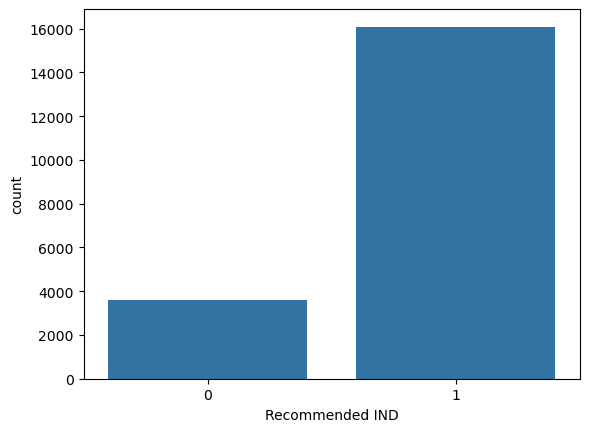

In [22]:
sns.countplot(x = df['Recommended IND'])

The data in the target *Recommended IND* is imbalanced. The observation with positive Recommended IND (1) outweigh the negative (0). Therefore, using accuracy may not efficient.

There are 4 scoring metrics are chosen to evaluate model performance:

1. <b>Precision:</b>

+ Precision is chosen because the impact of False Positive (the ML model predicts an item is recommended, but it is actually not) is significant.

+ It affects on both business work and customer experience. It is annoying for customers when they are recommended a product that they do not really care about. Moreover, a company may waste money and time on a product that is not noticed by customers.

2. <b>Recall:</b>

+ Recall is chosen because the impact of False Negative (the ML Model predicts an item is not recommended by customers, but it actually is) is also high.

+ The impact mostly on business work. If an item is recommended by customers, but the model fails to predict it, the chances to making that item viral will decreased, negatively affecting marketing and product development strategies of the company.

3. <b>Specificity:</b>

+ Specificity is chosen because of the imbalance between 2 labels in *Recommended IND*.

+ The records with "Not recommended" label is too less, compared to "Recommended" label. Evaluating through precision and recall, which mainly consider records with "Recommended" label, may not accurate enough. Specificity need to be applied as an independent score metrics for the False labels.

4. <b>F1:</b>

+ Both False Positive or False Negative cases can cause significant impact on the real life. Therefore, F1 should be considered as a metric to balance between them. It can show a general score of model performing, regardless of imbalanced labels.

In [23]:
# Function to run 5 fold cross validation and visualize training and validating results
def test_model(ML_model, data, count_vectors, unweighted_vectors, weighted_vectors, text_predictor = 'Title and Review', other_predictors = [], target = 'Recommended IND', scoring = ['precision', 'recall', 'specificity', 'f1']):
    '''
    Train and validate ML model using count vectors, unweighted vectors, weighted vectors to compare performance
    Args:
      ML_model: Machine Learning Classification model
      data (pd.DataFrame): the pd.DataFrame containing dataset to train and test
      count_vectors (numpy.ndarray): count vectors for Bag-of-word model of text_predictor
      weighted_vectors (numpy.ndarray): weighted vectors for embedding model of text_predictor
      unweighted_vectors (numpy.ndarray): unweighted vectors for embedding model of text_predictor
      text_predictor (str): a text attribute that is used to train and test model
      other_predictors (List[str]): a list of other predictors that is used to train and test model
      target (str): the attribute that is the target of ML model
    Returns:
      None: This is a void to print out evaluation result for model performance based on 5-fold cross validation
    '''
    # set up figure for visualizing validation result
    # Changed to 3 rows to accommodate new training and validation bar plots
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    plt.suptitle(f"Train model with attributes: \n{text_predictor}, {', '.join(other_predictors)}", fontsize = 16)

    # ---- Prepare data to train ----
    # separate encoded columns
    encoded_cols = onehot_encoder.get_feature_names_out(['Division Name', 'Class Name'])
    for col in ['Division Name', 'Class Name']:
      if col in other_predictors:
        other_predictors.remove(col)
        other_predictors.extend([c for c in encoded_cols if c.find(col) != -1])

    # integrate extra columns into text feature representations
    X_extra = np.array(df[other_predictors])

    # define predictors and target
    X_c = hstack([count_vectors, X_extra])
    X_uw = np.hstack([unweighted_vectors, X_extra])
    X_w = np.hstack([weighted_vectors, X_extra])
    y = data[target]


    # ---- Define validation (K-Fold, extra scoring strategies) ----
    def specificity(y_true, y_pred):
      """
      Calculates the specificity score from a confusion matrix.
      Specificity = TN / (TN + FP)
      """
      tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
      # Handle case where (tn + fp) is zero to prevent division by zero error
      if (tn + fp) == 0:
          return 0
      return tn / (tn + fp)

    score_metrics = {}
    for metric in scoring:
      if metric == 'specificity':
        score_metrics[metric] = make_scorer(specificity) # The make_scorer function converts our specificity function into a valid scikit-learn scorer
      else:
        score_metrics[metric] = metric

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # ---- Train and validate model ----

    for i, (title, X) in enumerate([('Count Vectors', X_c), ('Unweighted Vectors', X_uw), ('Weighted Vectors', X_w)]):
      # Set return_train_score=True to get training results
      cv_results = cross_validate(ML_model, X, y, cv=cv, scoring=score_metrics, return_train_score=True)

      # put validation result in DataFrame for visualization later
      train_results_df = pd.DataFrame()
      validation_results_df = pd.DataFrame()
      for metric in score_metrics:
        train_results_df[metric] = cv_results[f'train_{metric}']
        validation_results_df[metric] = cv_results[f'test_{metric}']

      # Get the mean and standard deviation for plotting
      train_means = train_results_df.mean() # get mean of all training results for 5 time test (5 fold)
      train_stds = train_results_df.std() # get deviation of 5 training results for each time test (fold)
      validation_means = validation_results_df.mean() # get mean of validating results
      validation_stds = validation_results_df.std() # get deviation of validating results
      metrics = train_results_df.columns # get scoring metrics
      x_pos = np.arange(len(metrics)) # generate labels for x axis: list all metrics

      # print(f"\"{title.split(' ')[0]}\", ", end = "")

      # Subplot 1: Bar Chart to show the mean scores with Error Bars for the standard deviation
      # This plot shows both training and validation scores for direct comparison
      axes[i].bar(x_pos - 0.2, train_means, yerr = train_stds, capsize = 5, width = 0.4, label = 'Training')
      axes[i].bar(x_pos + 0.2, validation_means, yerr = validation_stds, capsize = 5, width=0.4, label = 'Validation')
      axes[i].set_title(f'{title}\nMean Scores with Standard Deviation')
      axes[i].set_ylabel('Score')
      axes[i].set_ylim(0, 1.05) # set y limit higher than 1 to have space for number label to be presented
      axes[i].set_xticks(x_pos)
      axes[i].set_xticklabels(metrics)
      axes[i].grid(axis = 'y', linestyle = '--', alpha = 0.7) # set horizontal grid lines for the scores
      axes[i].legend() # show legend: training, validation
      for j, (train_val, val_val) in enumerate(zip(train_means, validation_means)):
          axes[i].text(j - 0.2, train_val + 0.03, f'{train_val:.2f}', ha = 'center', fontweight = 'bold')
          axes[i].text(j + 0.2, val_val + 0.03, f'{val_val:.2f}', ha = 'center', fontweight = 'bold')
          # print(f"{val_val:.2f}, ", end = "")
      print()

    plt.tight_layout()
    plt.show()

#### 3.2.2. Choose Machine Learning models
This section choose Machine Learning models that are considered to be most efficient in handling the classification task required.

The chosen Machine Learning models are Logistic Regression, Adaptive Boosting (AdaBoost) Classification, Support Vector Machine (SMV).

1. **Logistic Regression**: This model is fast in training, easy to understand, and its results are easy to be interpreted. Therefore, this model can be used as a "baseline model" to debug, evaluate the suitability of the dataset for this problem (like which word or attribute contributes the best for this classification problem).

2. **SVM**: This model is can handle a vast number of features (work well with high-dimensional spaces), optimize the separation boundary between recommended and not recommended review, and can also tackle non-linear data pattern, which is a weakness of Logistic Regression. However, the model is complex, and its results are not easy to be interpreted (that is why Logistic Regression is used as a baseline).

3. **LightGBM**: we have conducted comparative analysis with diverse models (LightGBM, XGBoost, Adaboost, Catboost) training in different scenarios (Refered to model_experiment.ipynb), and see that LightGBM has the best performance. This model is much more complex, with slower training speed, but can bring up highly accurated results. Therefore, it is used to provide a more accurated result, and handle the rise of data complexity in the future. The model results are voted by a group of tree-based model, thus can efficiently dealing with scaled data, non-linear data pattern, and detailed categorical data (like the *Clothing ID* attribute).

**The chosen Vocab**:
Vocab with bigrams, trigrams and quadgrams collocations through experiment it shows meaningful collocations like: 'love at first sight', 'was pleasantly surprised by', and 'worth every penny' show positive sentimental values and useful for the model to predict better. By this, a richer vocabulary better represents the various ways customers express satisfaction or dissatisfaction, which directly relates to recommendation behavior (Refered to model_experiment.ipynb).


### 3.3. Training Machine Learning (ML) Model
This section trains ML models using text attributes ("Title", "Review Text", both) in 3 different forms (count vectors, unweighted vectors, weighted vectors).

#### 3.3.1 Logistic Regression

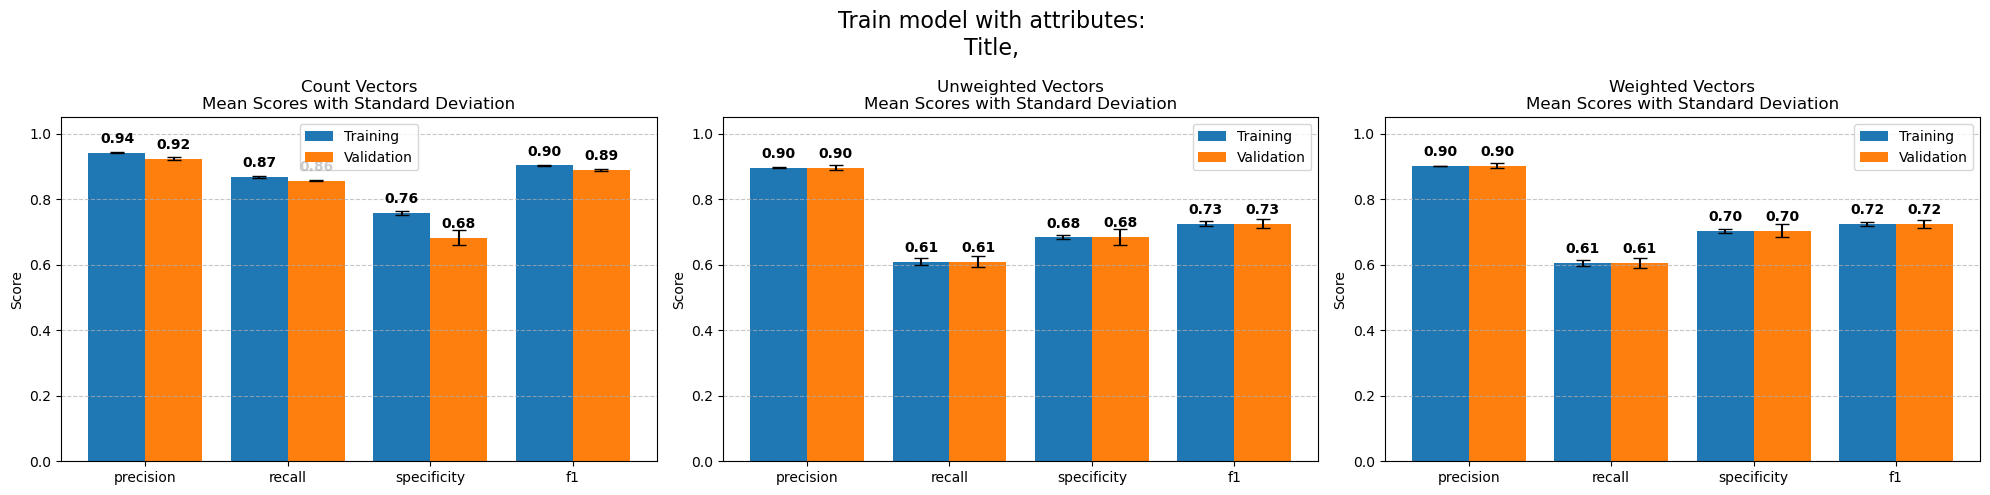

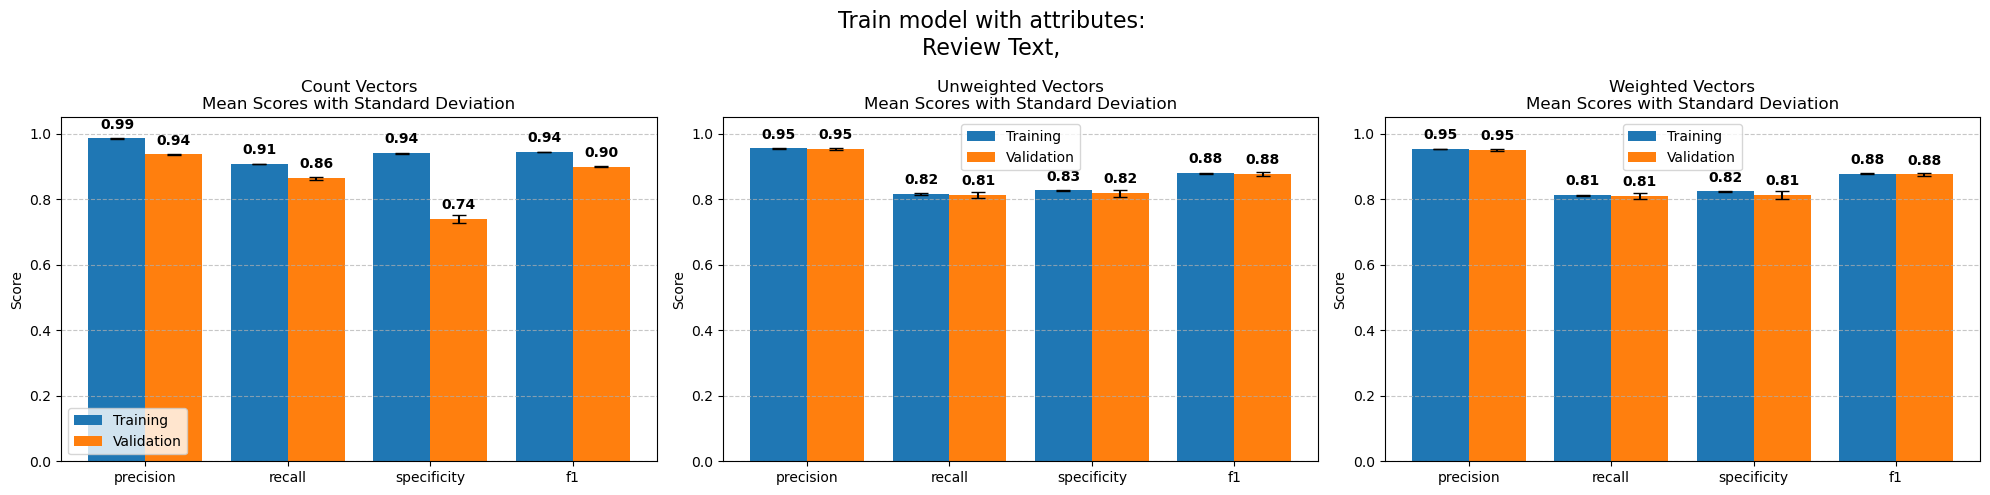

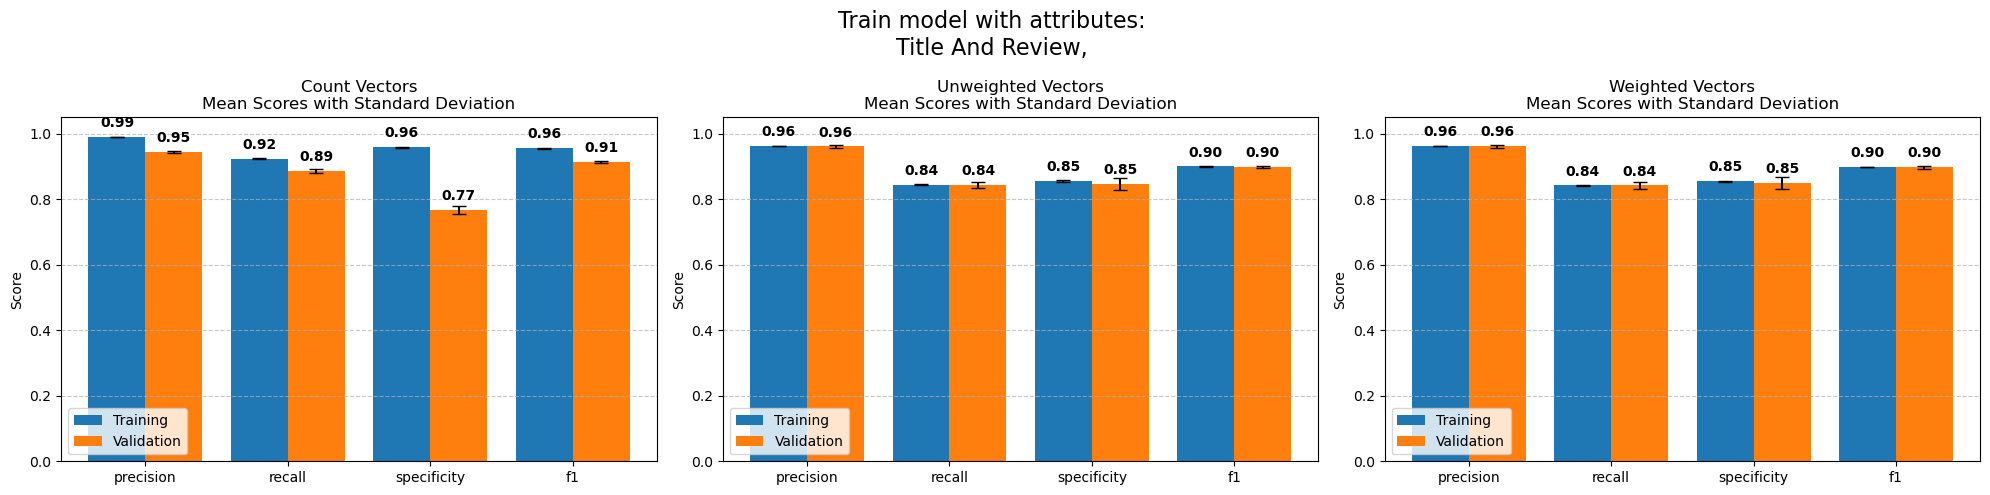

In [24]:
# build Logistic Regression

# train with 'Title'
clf = LogisticRegression(max_iter = 1000, solver = "lbfgs", class_weight = 'balanced')
count_vectors, unweighted_vectors, weighted_vectors = calc_vectors(df, 'Title', vocab_title, fasttext_title_model)
test_model(clf, df, count_vectors, unweighted_vectors, weighted_vectors, 'Title')

# train with 'Review Text'
clf = LogisticRegression(max_iter = 1000, solver = "lbfgs", class_weight = 'balanced')
count_vectors, unweighted_vectors, weighted_vectors = calc_vectors(df, 'Review Text', vocab_text, fasttext_text_model)
test_model(clf, df, count_vectors, unweighted_vectors, weighted_vectors, 'Review Text')

# train with 'Title And Review'
clf = LogisticRegression(max_iter = 1000, solver = "lbfgs", class_weight = 'balanced')
count_vectors, unweighted_vectors, weighted_vectors = calc_vectors(df, 'Title And Review', vocab_both, fasttext_both_model)
test_model(clf, df, count_vectors, unweighted_vectors, weighted_vectors, 'Title And Review')

**Evaluate Logistic Regression model, trained with *Title*, *Review Text*, and *Title And Review* respectively:**

Through all models trained, there are some insights can be concluded:
+ The test scores of 5 folds have small variance: The model is relatively stable.
+ The scores in both training and validating dataset are nearly equal: The model does not face to overfitting issue, except the case when training with Count Vectors of Title And Review.
+ The scores of all 5 metrics are nearly the same: The model performance is balanced between handling False Positive and False Negative.
+ The scores when training with Title is the lowest, while the scores when training with Title And Review is the highest: Adding more information may enhance model performance, but this insight may need to be verified more.

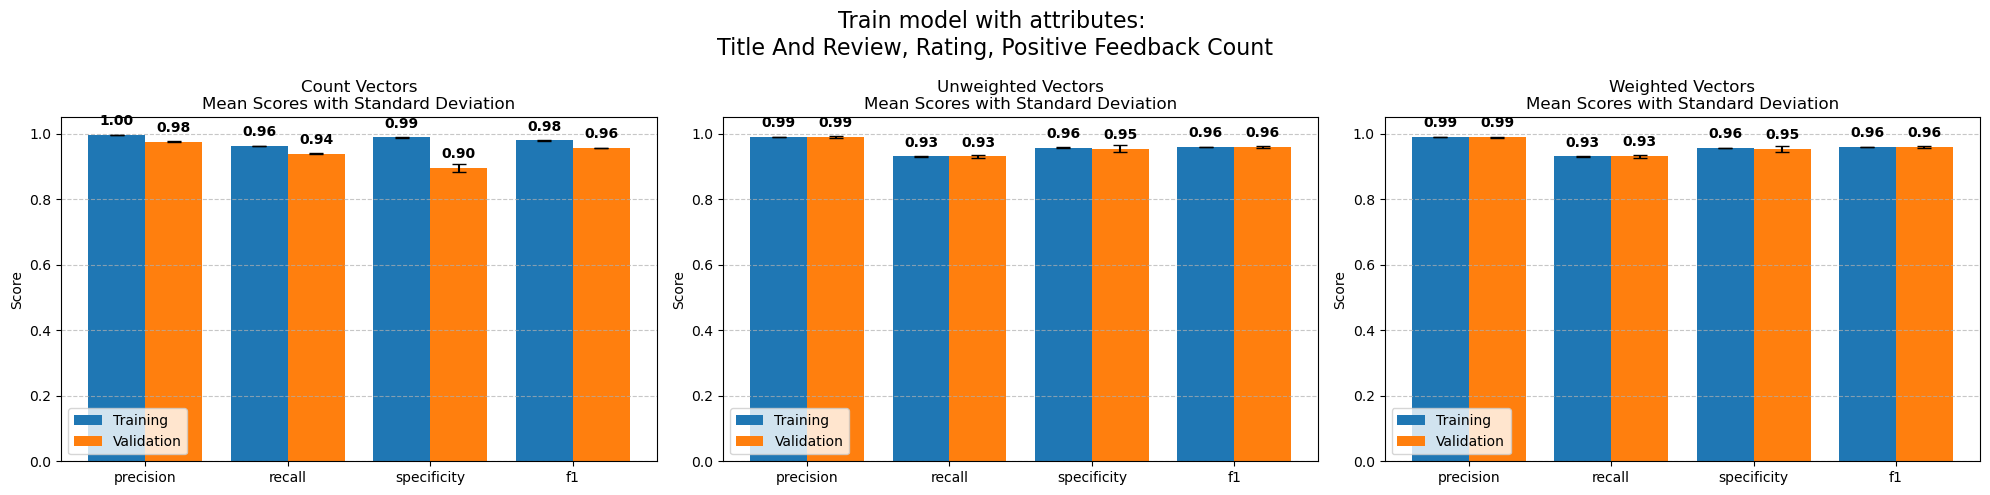

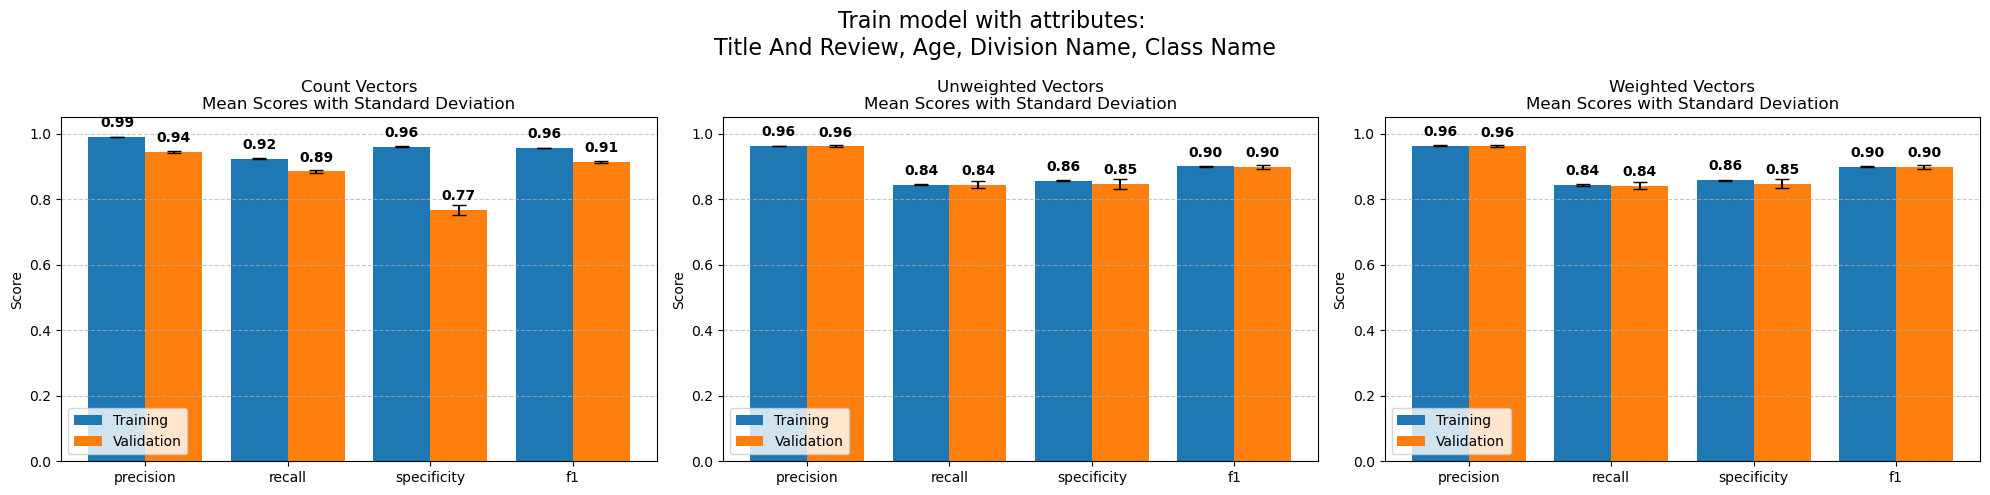

In [25]:
# train Logistic Regression with more attributes

# try to add more attributes: 'Rating', 'Positive Feedback Count'
clf = LogisticRegression(max_iter = 1000, solver = "lbfgs", class_weight = 'balanced')
count_vectors, unweighted_vectors, weighted_vectors = calc_vectors(df, 'Title And Review', vocab_both, fasttext_both_model)
test_model(clf, df, count_vectors, unweighted_vectors, weighted_vectors, 'Title And Review', ['Rating', 'Positive Feedback Count'])

# try to add other attributes: 'Age', 'Division Name', 'Class Name'
clf = LogisticRegression(max_iter = 1000, solver = "lbfgs", class_weight = 'balanced')
count_vectors, unweighted_vectors, weighted_vectors = calc_vectors(df, 'Title And Review', vocab_both, fasttext_both_model)
test_model(clf, df, count_vectors, unweighted_vectors, weighted_vectors, 'Title And Review', ['Age', 'Division Name', 'Class Name'])


**Evaluate Logistic Regression model, trained with *Title*, *Review Text*, *Rating*, *Positive Feedback Count*:**
+ In general, all 3 methods of document representation is still efficient in training Logistic Regression model.
+ Using Unweighted or Weighted Vectors may be slightly more efficient in identifying not recommended reviews (since their specificity score are higher than that of Count Vectors), while training with Count Vectors shows overfitting issue.

Compare model performances, based on different data volume:

+ The performance of all 3 models become better when adding more data.

+ Adding *Rating* and *Positive Feedback Count* strongly improve the specificity: This may due to the strong correlation between those with *Recommended IND* (target), the model probably relied on those highly correlated variables to compensate for the limited number reviews with "0" target label. However, adding *Age*, *Division Name*, *Class Name* makes the scores of all 3 models go down. Moreover, the specificity of all 3 models even worse than when training with only *Title And Review*. Therefore, not every time adding more information will improve the model performance. A variable with high correlation (or causation) with the target, may strongly improve the model performance, while a variable with low relationship may confuse the model and make its performance even worse.

#### 3.2.2. Linear SVM

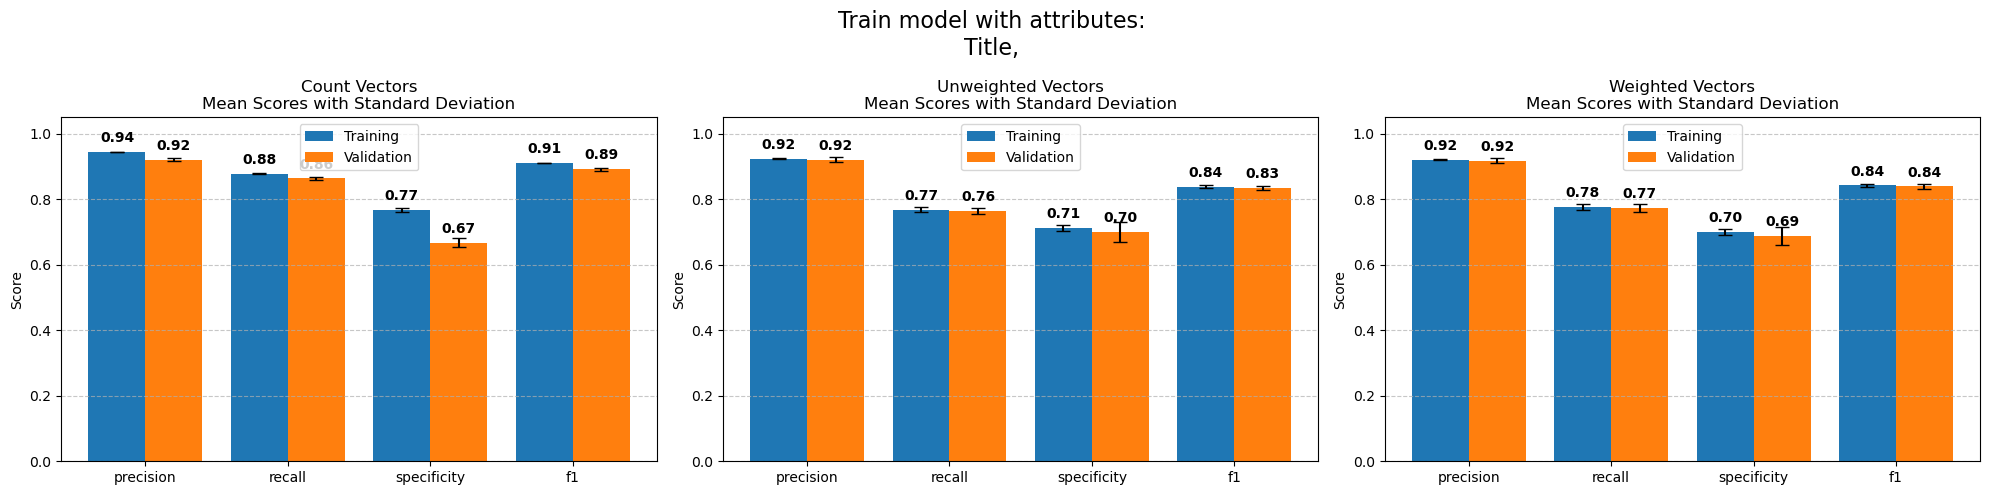

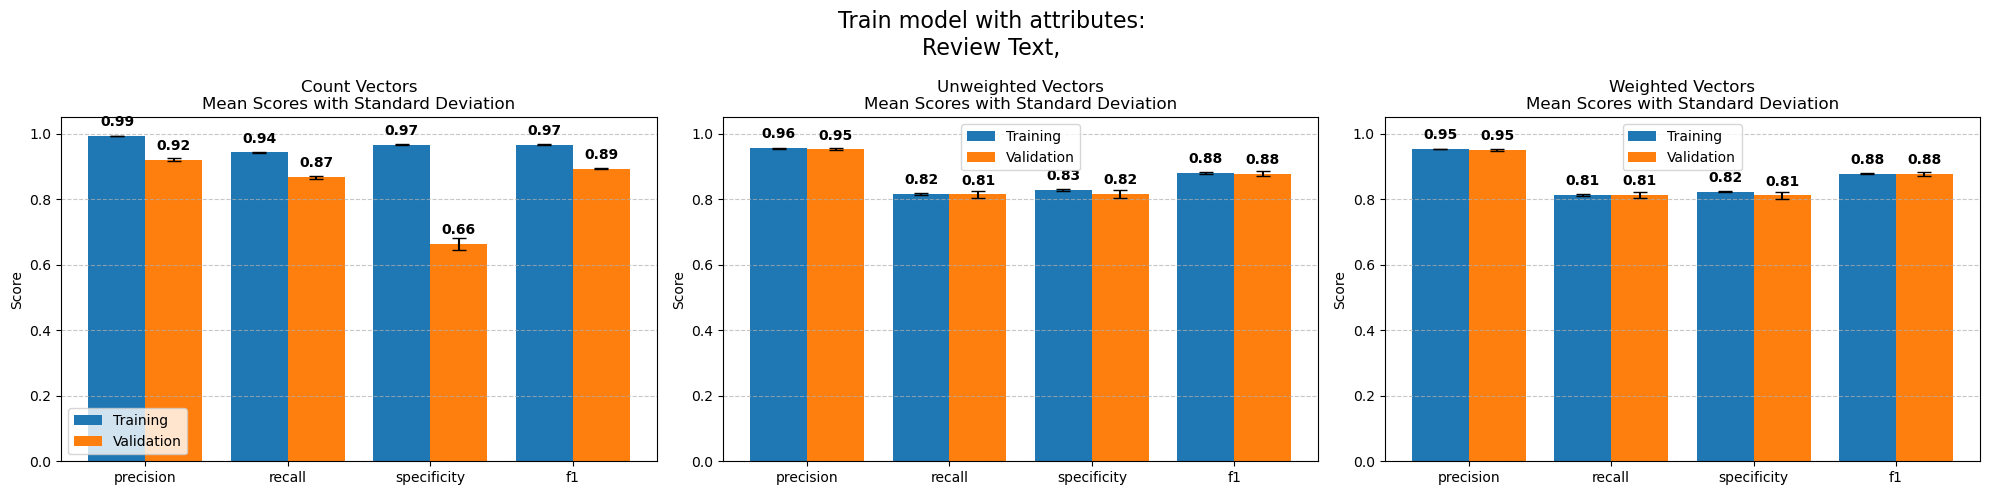

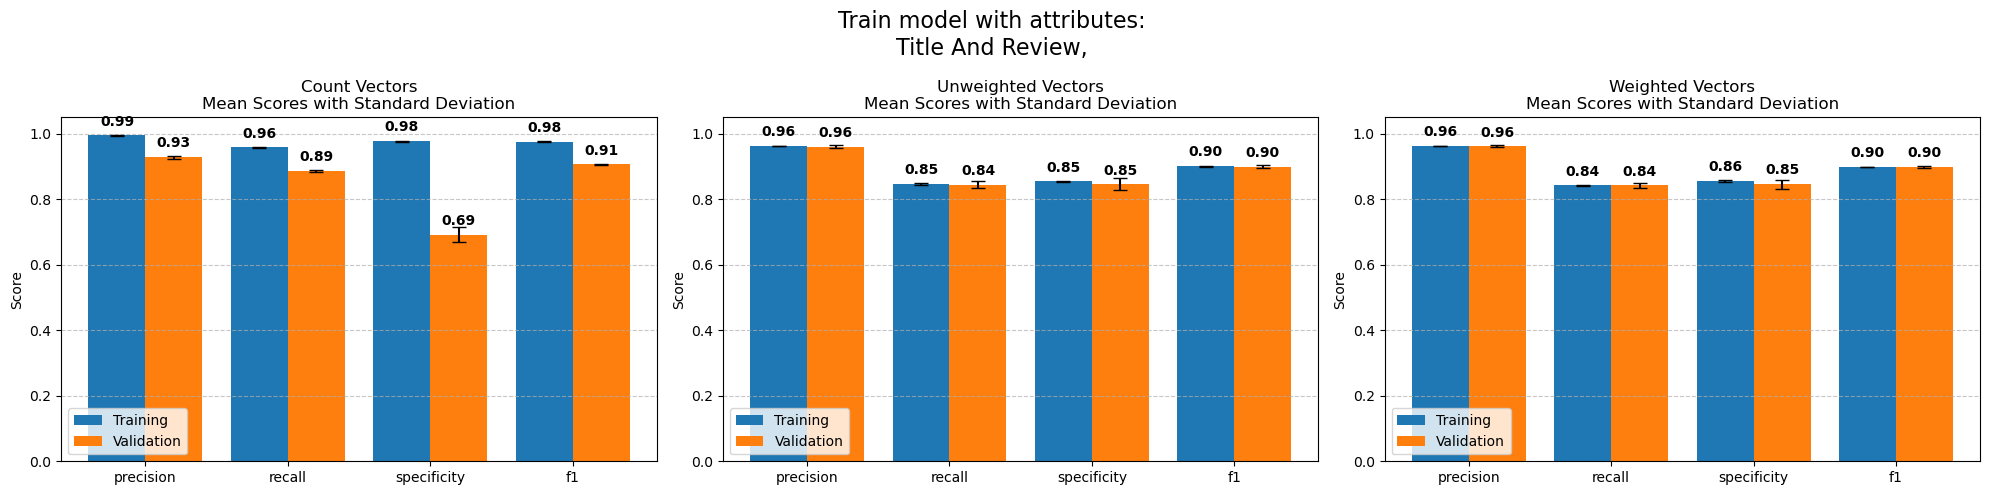

In [26]:
# train SVM with LinearSVC()

# ---- Train with "Title" ----
# Count vectors (sparse), 2 Embeddings vectors (dense)
count_vectors, unweighted_vectors, weighted_vectors = calc_vectors(df, 'Title', vocab_title, fasttext_title_model)
scaler_uw = StandardScaler()
unweighted_vectors_scaled = scaler_uw.fit_transform(unweighted_vectors) # Scale dense vectors
scaler_w = StandardScaler()
weighted_vectors_scaled = scaler_w.fit_transform(weighted_vectors) # Scale dense vectors

svc = LinearSVC(max_iter=5000, random_state=42, class_weight='balanced')
test_model(svc, df, count_vectors, unweighted_vectors_scaled, weighted_vectors_scaled, 'Title')

# ---- Train with "Review Text" ----
# Count vectors (sparse), 2 Embeddings vectors (dense)
count_vectors, unweighted_vectors, weighted_vectors = calc_vectors(df, 'Review Text', vocab_text, fasttext_text_model)
scaler_uw = StandardScaler()
unweighted_vectors_scaled = scaler_uw.fit_transform(unweighted_vectors) # Scale dense vectors
scaler_w = StandardScaler()
weighted_vectors_scaled = scaler_w.fit_transform(weighted_vectors) # Scale dense vectors

svc = LinearSVC(max_iter=5000, random_state=42, class_weight='balanced')
test_model(svc, df, count_vectors, unweighted_vectors_scaled, weighted_vectors_scaled, 'Review Text')

# ---- Train with "Title And Review" ----
# Count vectors (sparse), 2 Embeddings vectors (dense)
count_vectors, unweighted_vectors, weighted_vectors = calc_vectors(df, 'Title And Review', vocab_both, fasttext_both_model)
scaler_uw = StandardScaler()
unweighted_vectors_scaled = scaler_uw.fit_transform(unweighted_vectors) # Scale dense vectors
scaler_w = StandardScaler()
weighted_vectors_scaled = scaler_w.fit_transform(weighted_vectors) # Scale dense vectors

svc = LinearSVC(max_iter=5000, random_state=42, class_weight='balanced')
test_model(svc, df, count_vectors, unweighted_vectors_scaled, weighted_vectors_scaled, 'Title And Review')

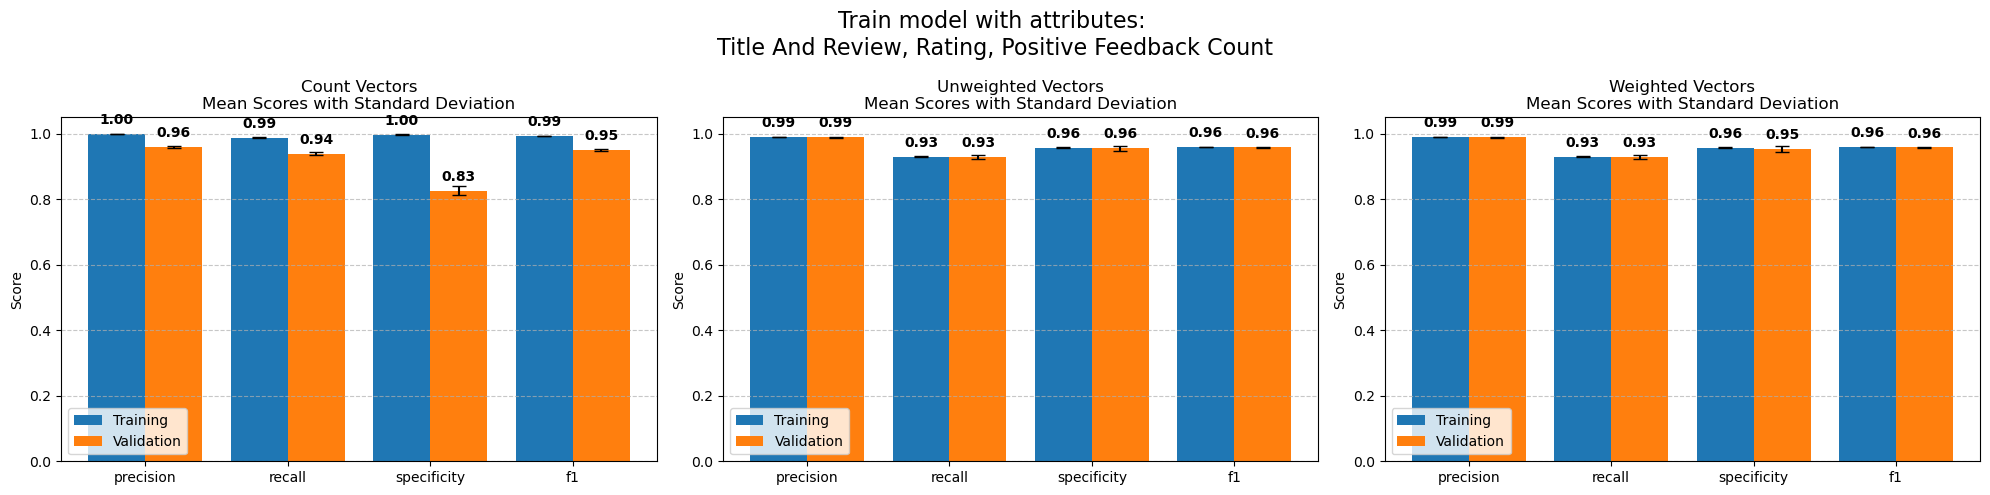

In [27]:
# ---- Train SVM with "Title And Review" and Features----
# Count vectors (sparse), 2 Embeddings vectors (dense)
count_vectors, unweighted_vectors, weighted_vectors = calc_vectors(df, 'Title And Review', vocab_both, fasttext_both_model)
scaler_uw = StandardScaler()
unweighted_vectors_scaled = scaler_uw.fit_transform(unweighted_vectors) # Scale dense vectors
scaler_w = StandardScaler()
weighted_vectors_scaled = scaler_w.fit_transform(weighted_vectors) # Scale dense vectors

svc = LinearSVC(max_iter=5000, random_state=42, class_weight='balanced')
test_model(svc, df, count_vectors, unweighted_vectors_scaled, weighted_vectors_scaled, 'Title And Review', ['Rating', 'Positive Feedback Count'])

**Comments on training of Title only**
- In overall, the model training with Title performs unstable among 3 types of vectors. To be specific, counted-vectors trained. despite having high scores, shows overfitting problem, while the other two have low recall and specificity score (under 0.8).

**Comments on training of Review Text only**
- The model performs well with weighted and unweighted vectors, whilst, the count_vectors trained shows serious overfitting issue in both specificity and recall metrics.

**Comments on training of both Review Text and Title**
- The model does not perform well with counted vectors as the overfitting shows in specificity score (differences of over 0.3 between training and validating scores).
- Most of the metrics have been slightly improved compared to training with Title alone.

**Comments on training of both Review Text and Title, and more features**
- Again, adding features that have high correlation with the target strongly enhanced the model performance, but still cannot solve the overfitting issue of Count Vectors trained model.



#### 3.3.3. LightBoost Classification

In [28]:
# Define LightGBM model with parameters to handle class imbalance
lgb_clf = lgb.LGBMClassifier(
    boosting_type='gbdt',           # Gradient Boosting Decision Tree
    n_estimators=100,               # Number of trees
    learning_rate=0.05,             # Learning rate
    num_leaves=31,                  # Max number of leaves in one tree
    max_depth=-1,                   # No limit on depth
    class_weight='balanced',        # Automatically adjust weights inversely proportional to class frequencies
    min_child_samples=20,           # Minimum samples required in a leaf
    subsample=0.8,                  # Subset of training data to use for each tree
    colsample_bytree=0.8,           # Subset of features to use for each tree
    reg_alpha=0.1,                  # L1 regularization
    reg_lambda=1.0,                 # L2 regularization
    random_state=42,                # For reproducibility
    verbose = 0,                    # No logs on console
)

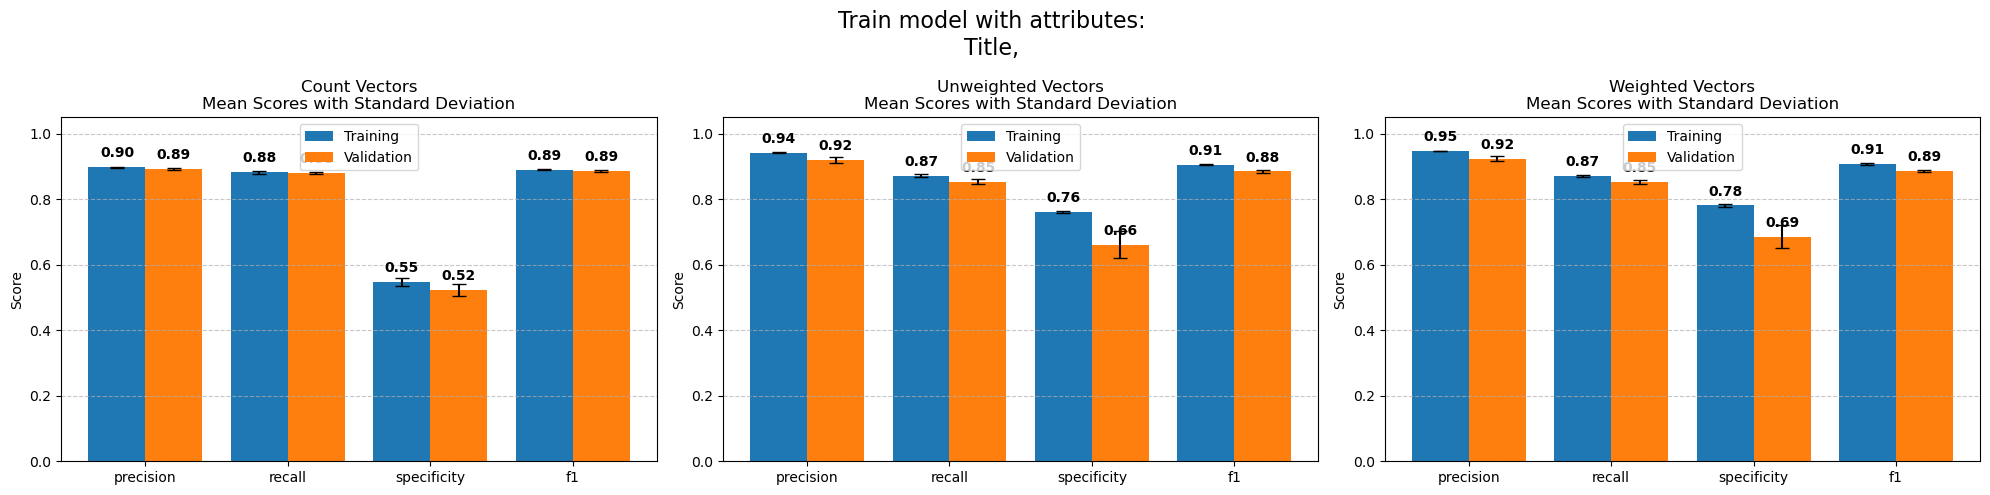

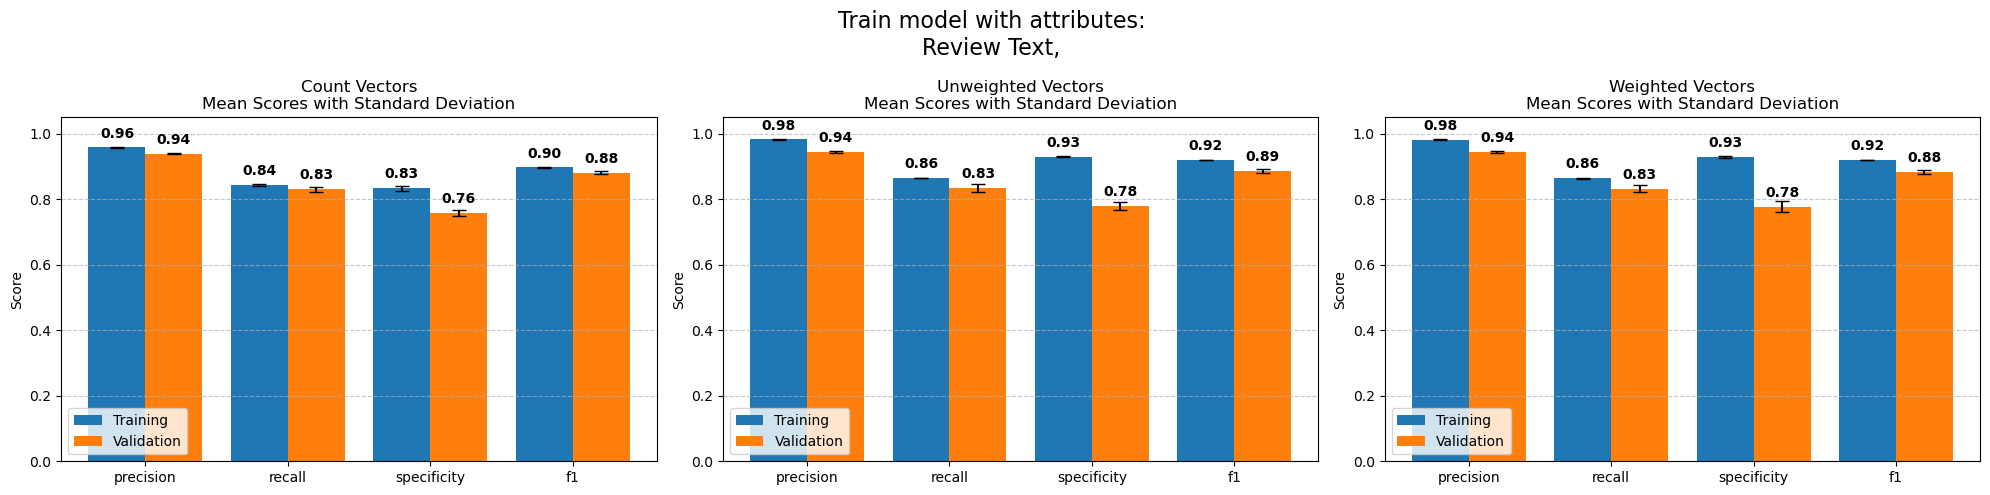

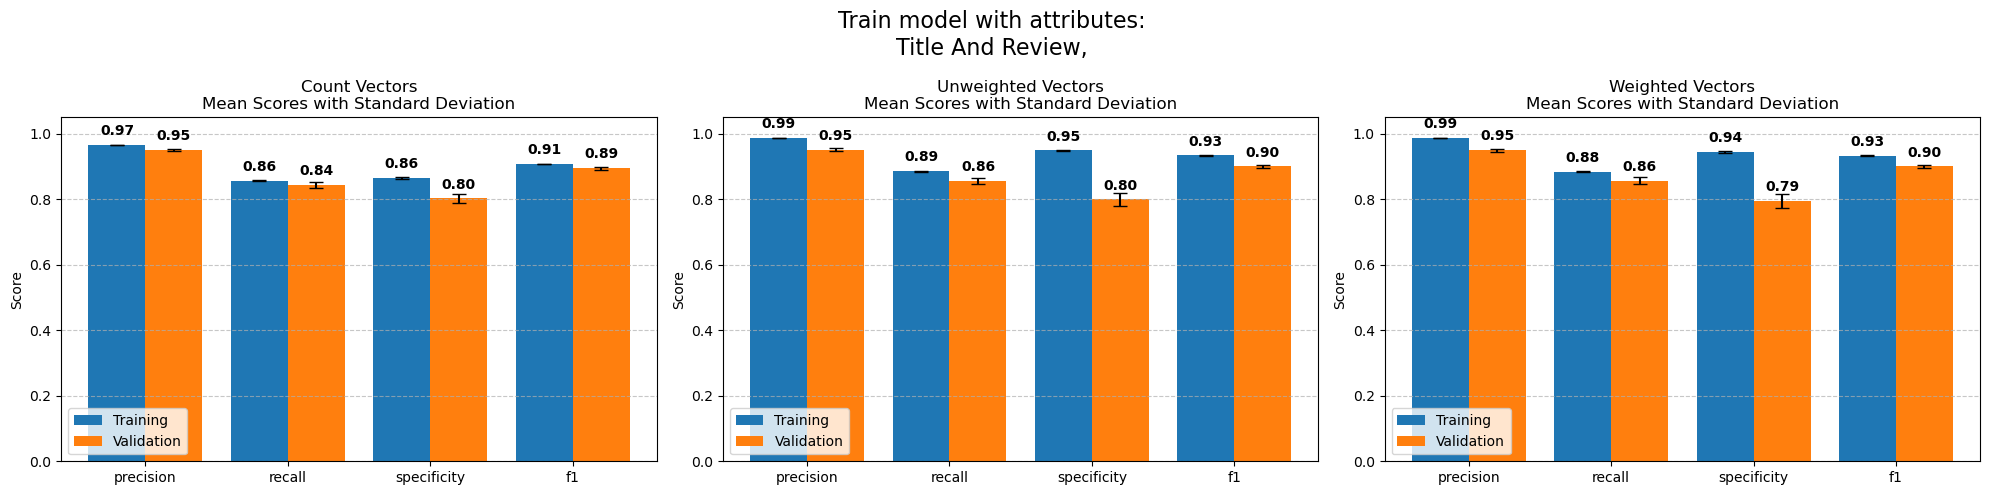

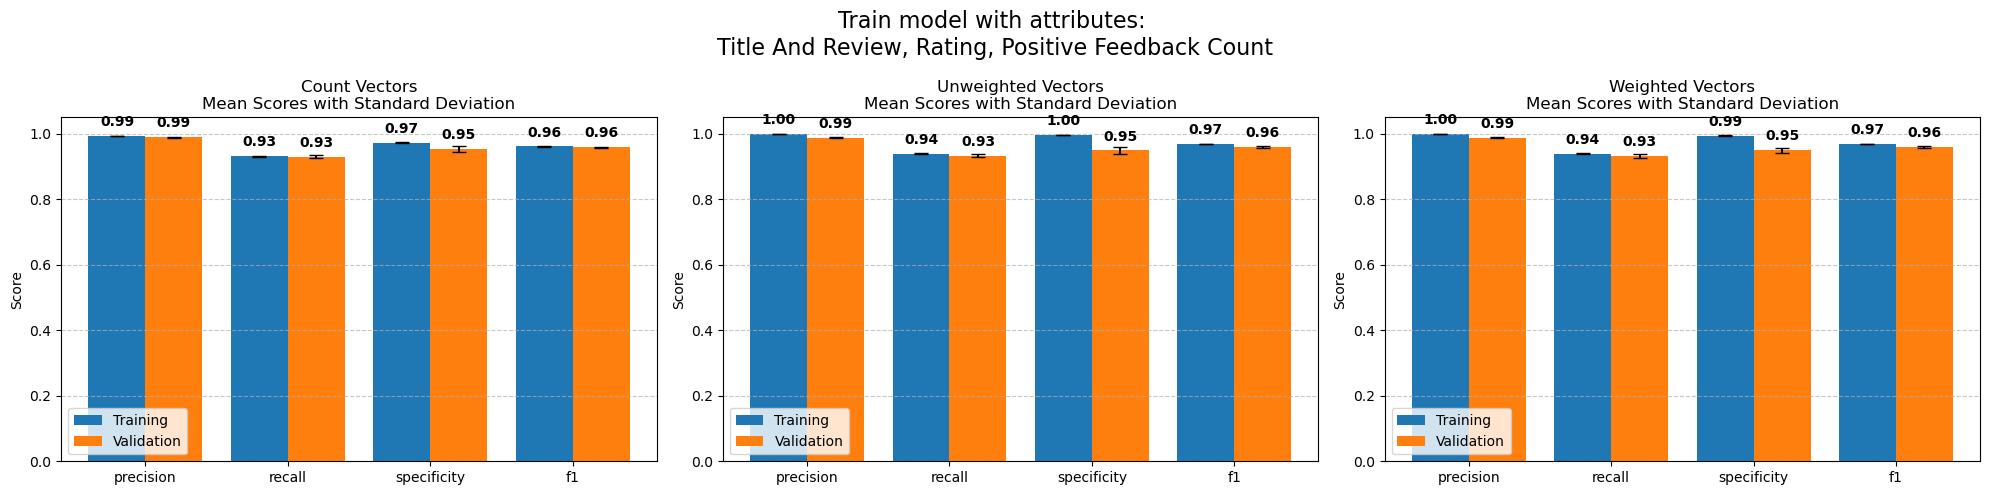

In [29]:
# Train LightBoost model

# Train with Title
count_vectors, unweighted_vectors, weighted_vectors = calc_vectors(df, 'Title', vocab_title, fasttext_text_model)
test_model(lgb_clf, df, count_vectors, unweighted_vectors, weighted_vectors, 'Title')

# Train with Review Text
count_vectors, unweighted_vectors, weighted_vectors = calc_vectors(df, 'Review Text', vocab_text, fasttext_text_model)
test_model(lgb_clf, df, count_vectors, unweighted_vectors, weighted_vectors, 'Review Text')

# Train with Title And Review
count_vectors, unweighted_vectors, weighted_vectors = calc_vectors(df, 'Title And Review', vocab_both, fasttext_both_model)
test_model(lgb_clf, df, count_vectors, unweighted_vectors, weighted_vectors, 'Title And Review')

# Train with Title And Review, Rating, Positive Feedback Count
count_vectors, unweighted_vectors, weighted_vectors = calc_vectors(df, 'Title And Review', vocab_both, fasttext_both_model)
test_model(lgb_clf, df, count_vectors, unweighted_vectors, weighted_vectors, 'Title And Review', ['Rating', 'Positive Feedback Count'])

**Comments on the training with Title:**
- The model performs unstable among 3 types of vectors. Noticeably, count vectors trained has the lowest specificity score. For weighted and unweighted vectors, the models trained's results give similar scores but shows overfitting issues in specificity metrics (0.1).

**Comments on the training with Review Text:**
- The model performs moderately stable. However, overfitting issue still occurs in unweighted and weighted vectors trained model (almost 0.2).

**Comments on the training with Title And Review:**
- Noticeably, the count_vectors outperforms the others that the overfitting issue recorded 0.15 in specificity.

**Comments on the training with Title And Review, Rating, Positive Feedback Count:**
- In overall, 3 models show stable performance scores. The overfitting issue is disappeared thanks to high correlation between Rating and the target.


## 4. Conslusion:

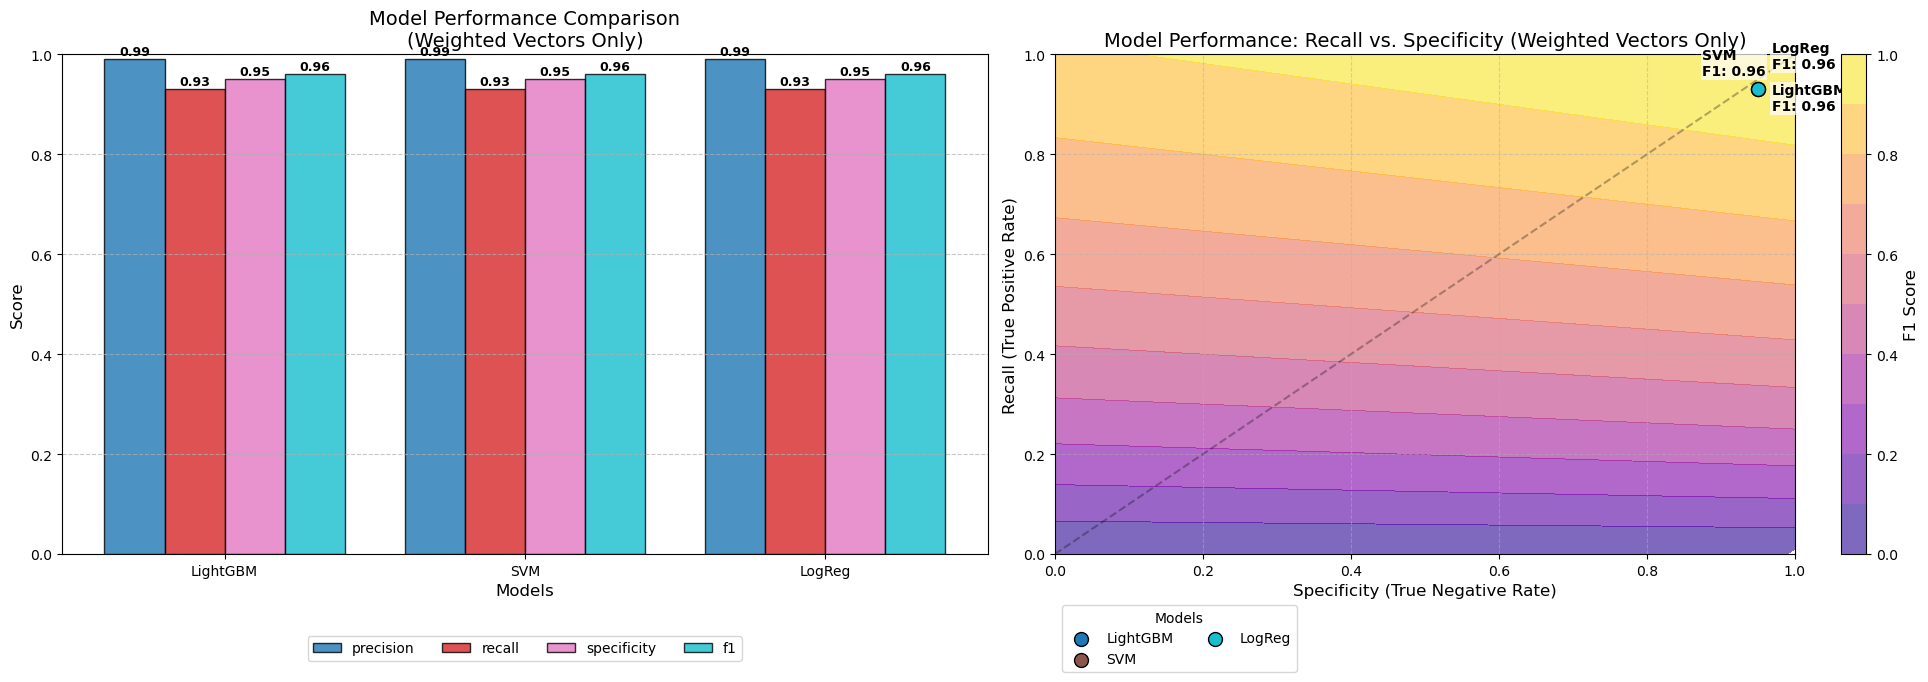

In [30]:
# Create a clean model comparison visualization with the new data
# First, let's fix the data structure
models_data = [
    # LightGBM with Title And Review
    ["LightGBM", "Count", 0.99, 0.93, 0.95, 0.96],
    ["LightGBM", "Unweighted", 0.99, 0.93, 0.95, 0.96],
    ["LightGBM", "Weighted", 0.99, 0.93, 0.95, 0.96],

    # SVM with Title And Review and Features
    ["SVM", "Count", 0.96, 0.94, 0.83, 0.95],
    ["SVM", "Unweighted", 0.99, 0.93, 0.95, 0.96],
    ["SVM", "Weighted", 0.99, 0.93, 0.95, 0.96],

    # LogReg with Title And Review and Features
    ["LogReg", "Count", 0.98, 0.94, 0.90, 0.96],
    ["LogReg", "Unweighted", 0.99, 0.93, 0.95, 0.96],
    ["LogReg", "Weighted", 0.99, 0.93, 0.95, 0.96]
]

df_models = pd.DataFrame(
    models_data,
    columns=["model_name", "vector_type", "precision", "recall", "specificity", "f1"]
)

# Create figures for both visualizations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# === VISUALIZATION 1: BAR CHART FOR MODEL COMPARISON ===
# Select only weighted vectors for the bar chart
weighted_df = df_models[df_models["vector_type"] == "Weighted"].copy()

# Set width of bars
bar_width = 0.2
index = np.arange(len(weighted_df))
metrics = ["precision", "recall", "specificity", "f1"]
colors = plt.cm.tab10(np.linspace(0, 1, len(metrics)))

# Plot grouped bars for each metric
for i, metric in enumerate(metrics):
    offset = bar_width * (i - 1.5)
    bars = ax1.bar(
        index + offset,
        weighted_df[metric],
        bar_width,
        label=metric,
        color=colors[i],
        alpha=0.8,
        edgecolor='black',
        linewidth=1
    )

    # Add value labels above each bar
    for j, bar in enumerate(bars):
        height = bar.get_height()
        ax1.annotate(
            f'{height:.2f}',
            xy=(bar.get_x() + bar.get_width()/2, height),
            xytext=(0, 3),  # 3 points vertical offset
            textcoords="offset points",
            ha='center',
            fontsize=9,
            fontweight='bold'
        )

# Add labels, title and legend
ax1.set_xlabel('Models', fontsize=12)
ax1.set_ylabel('Score', fontsize=12)
ax1.set_title('Model Performance Comparison\n(Weighted Vectors Only)', fontsize=14)
ax1.set_xticks(index)
ax1.set_xticklabels(weighted_df['model_name'])
ax1.set_ylim(0, 1.0)
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# === VISUALIZATION 2: RECALL VS SPECIFICITY WITH F1 CONTOURS ===
# Filter to only show weighted vectors
weighted_df = df_models[df_models["vector_type"] == "Weighted"].copy()

# Create a grid of specificity and recall values to calculate F1 contours
specificity_grid = np.linspace(0.0, 1.0, 100)
recall_grid = np.linspace(0.0, 1.0, 100)
specificity_mesh, recall_mesh = np.meshgrid(specificity_grid, recall_grid)

# Define function to calculate precision from specificity and recall
def calculate_precision(specificity, recall, prevalence):
    return (recall * prevalence) / (recall * prevalence + (1 - specificity) * (1 - prevalence))

# Define function to calculate F1 from precision and recall
def calculate_f1(precision, recall):
    return 2 * (precision * recall) / (precision + recall + 1e-10)  # Add small epsilon to avoid division by zero

# Calculate precision from specificity and recall using Bayes' rule
p = 0.8  # Approximate prevalence of positive class
precision_mesh = calculate_precision(specificity_mesh, recall_mesh, p)
f1_mesh = calculate_f1(precision_mesh, recall_mesh)

# Plot F1 score contours
contour = ax2.contourf(specificity_mesh, recall_mesh, f1_mesh,
                     levels=np.linspace(0.0, 1.0, 11),  # 11 levels gives steps of 0.1
                     cmap='plasma',
                     alpha=0.6)
cbar = plt.colorbar(contour, ax=ax2)
cbar.set_label('F1 Score', fontsize=12)

# Plot each model as a scatter point
colors = plt.cm.tab10(np.linspace(0, 1, len(weighted_df)))
for i, (_, row) in enumerate(weighted_df.iterrows()):
    ax2.scatter(row['specificity'], row['recall'],
               s=100,
               c=[colors[i]],
               label=row['model_name'],
               marker='o',
               edgecolor='black',
               linewidth=1)

# Custom annotation positions to avoid overlap
annotation_positions = {
    'LightGBM': (10, -15),      # below right
    'SVM': (-40, 10),           # left
    'LogReg': (10, 15)          # above right
}

# Add model name AND F1 score labels with custom positions to avoid overlap
for i, (_, row) in enumerate(weighted_df.iterrows()):
    model_name = row['model_name']
    position = annotation_positions.get(model_name, (5, 5))  # default position if not specified

    ax2.annotate(f"{model_name}\nF1: {row['f1']:.2f}",
                xy=(row['specificity'], row['recall']),
                xytext=position,
                textcoords='offset points',
                fontsize=10,
                fontweight='bold',
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1))

# Configure the plot
ax2.set_xlabel('Specificity (True Negative Rate)', fontsize=12)
ax2.set_ylabel('Recall (True Positive Rate)', fontsize=12)
ax2.set_title('Model Performance: Recall vs. Specificity (Weighted Vectors Only)', fontsize=14)
ax2.set_xlim(0.0, 1.0)
ax2.set_ylim(0.0, 1.0)
ax2.grid(True, linestyle='--', alpha=0.5)

# Add a diagonal line for reference
ax2.plot([0, 1], [0, 1], 'k--', alpha=0.3)

# Create legend based on the scattered points - positioned outside the plot area
ax2.legend(title="Models", loc='lower left', bbox_to_anchor=(0.0, -0.25), ncol=2)

plt.tight_layout(rect=[0, 0, 1, 0.9])  # Make room for the legends
plt.subplots_adjust(bottom=0.2)
plt.show()

There is no perfect model.

Based on the comparative analysis of model performance metrics, LightGBM with weighted vectors emerges as the optimal model when 'Rating' and 'Positive Feedback Count' attributes are available. This is supported by:

1. Superior performance balance across all metrics (precision: 0.99, recall: 0.93, specificity: 0.95, F1: 0.96)
2. The model demonstrates consistently high performance across all vector types (count, unweighted, and weighted)
3. It effectively leverages the strong correlation between Rating (0.79 correlation with target) and the target variable without overfitting
4. The high specificity score (0.95) indicates excellent performance on the minority class despite class imbalance

When business constraints prevent the use of Rating and Positive Feedback Count attributes, SVM with weighted vectors represents the optimal choice, as evidenced by:

1. The best balance between precision (0.99) and specificity (0.95) among models trained without these critical features
2. The figure 4.1 shows that the overfitting occurs in Training with Title and Review Text with weighted vectors, LightGBM occurs overfiting in specifity score, which make the SVM and Logistic Regression more reliable.
2. SVM demonstrates minimal gap between training and validation performance, indicating good generalization
3. It maintains consistent performance across different text representation methods
4. The model shows robustness against the class imbalance problem as indicated by balanced precision, recall, and specificity metrics

Overall, to achieve the optimised model, adding more attributes in training models only viable when they have high correlation with the target. Therefore, adding Age and Class Name and Division Name, which have low correlation score with the target, reduce the models' performance. And among the vectors, the weighted vectors trained models usually give the highest result among 4 metric scores, because it provides more details about the important rates of each token.

Figure 4.1:

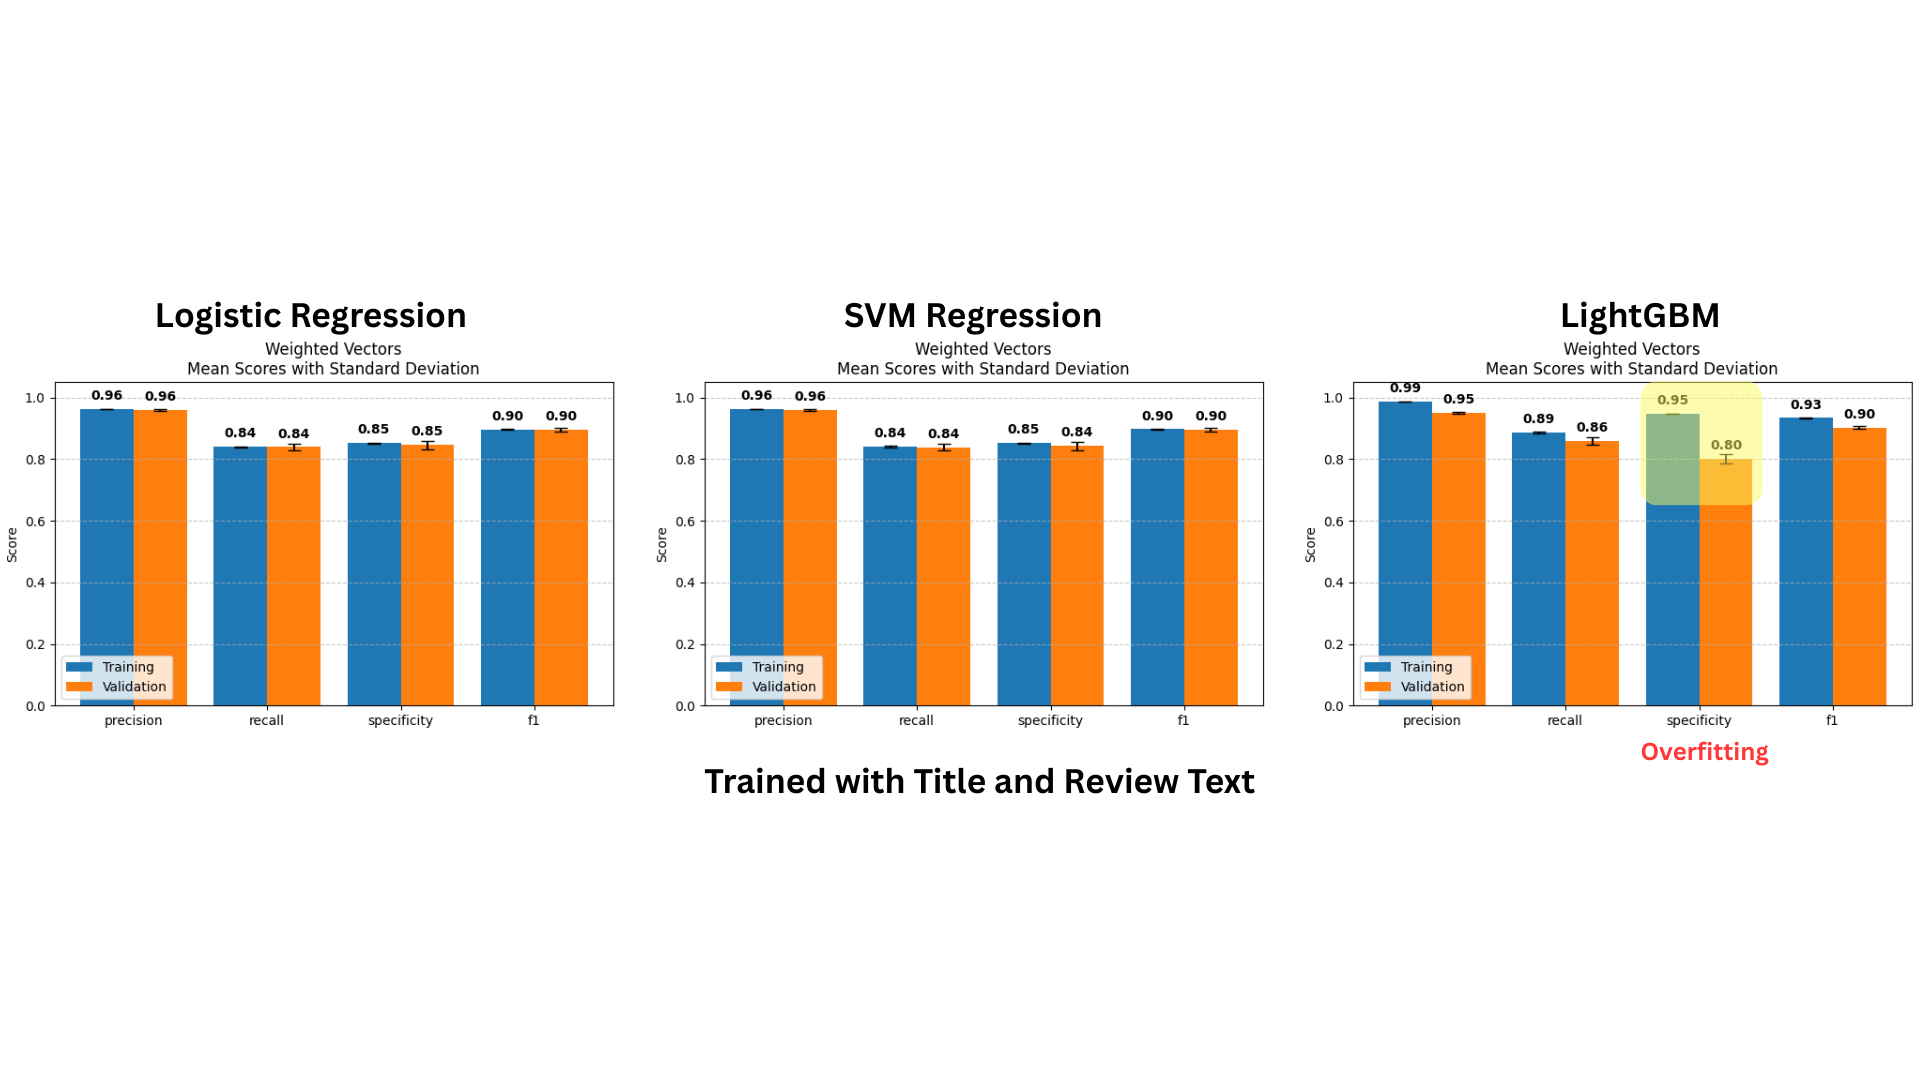

## 5. References
Bojanowski, P., Grave, E., Joulin, A., & Mikolov, T. (2017). *Enriching Word Vectors with Subword Information*. Transactions of the Association for Computational Linguistics, 5, 135-146.

Çano, E., & Morisio, M. (2019). *Word Embeddings for Sentiment Analysis: A Comprehensive Empirical Survey.* ArXiv, abs/1902.00753.

Devlin, J., Chang, M., Lee, K., & Toutanova, K. (2019). *BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding.* NAACL-HLT.

Joulin, A., Grave, E., Bojanowski, P., & Mikolov, T. (2016). *Bag of Tricks for Efficient Text Classification.* arXiv preprint arXiv:1607.01759.

Law, T., Shamdasani, J., & Broadbent, T. (2017). *Natural language processing approaches to understanding fashion-related text.* International Conference on AI and Mobile Services.

Mikolov, T., Chen, K., Corrado, G., & Dean, J. (2013). *Efficient Estimation of Word Representations in Vector Space.* ICLR Workshop Papers.

Mikolov, T., Grave, E., Bojanowski, P., Puhrsch, C., & Joulin, A. (2018). *Advances in Pre-Training Distributed Word Representations.* Proceedings of the International Conference on Language Resources and Evaluation (LREC).

Pennington, J., Socher, R., & Manning, C. D. (2014). *GloVe: Global Vectors for Word Representation.* Proceedings of the 2014 Conference on Empirical Methods in Natural Language Processing (EMNLP), 1532-1543.

Peters, M., Neumann, M., Iyyer, M., Gardner, M., Clark, C., Lee, K., & Zettlemoyer, L. (2018). *Deep Contextualized Word Representations.* Proceedings of NAACL-HLT.

Rogers, A., Kovaleva, O., & Rumshisky, A. (2020). *A Primer in BERTology: What We Know About How BERT Works.* Transactions of the Association for Computational Linguistics, 8, 842-866.


In [31]:
fasttext_both_model.save('fasttext_model.model')

In [13]:
# Train and Export models

# ---- Define text preprocessing pipeline (transform text to weighted vectors) ----
# Class to define custom sklearn Transformer
class TextToVectorTransformer(BaseEstimator, TransformerMixin):
  """
  A custom scikit-learn transformer that handles text preprocessing and
  converts it to weighted FastText vectors.
  """
  def __init__(self):
    self.vocab = None
    self.fasttext_model = None
    self.tfidf_vectorizer = None
    self.data_is_preprocessed = False

  def fit(self, X, y = None):
    """
    Fits the transformer by preprocessing the data and training the FastText model.
    
    Args:
        X (List[str]): The input text data.
        y (List[int], optional): The target variable. Not used in this transformer.
    """
    # Retrieve cleaned text and vocab (already processed in task 1)
    self.vocab = read_vocab('vocab_both.txt')
    
    # Train the FastText model on the preprocessed data
    self.fasttext_model = FastText.load('fasttext_model.model')
    
    # Fit the weighted vectorizer (TF-IDF)
    self.tfidf_vectorizer = TfidfVectorizer(analyzer='word', vocabulary=self.vocab, lowercase=True)
    self.tfidf_vectorizer.fit(X)
    
    self.data_is_preprocessed = True
    
    return self

  def transform(self, X):
    """
    Transforms new data using the fitted preprocessing steps and model.
    
    Args:
        X (List[str]): The new input text data.

    Returns:
        np.ndarray: The weighted vectors for the input data.
    """
    if self.vocab is None or self.fasttext_model is None or self.tfidf_vectorizer is None:
      print(self.vocab, self.fasttext_model, self.tfidf_vectorizer)
      raise RuntimeError("This transformer has not been fitted yet. Call .fit() before .transform().")
    
    # Generate weighted vectors using the stored vocab and model
    data = pd.DataFrame({
      'New Review': X if self.data_is_preprocessed else self.text_preprocessing(X)
    })
    weighted_vectors = self.calc_weighted_vectors(data, 'New Review', self.vocab, self.fasttext_model)
    self.data_is_preprocessed = False

    return weighted_vectors
  
  # Function to tokenize pd.DataFrame to corpus (a 2D list, each row stores tokens of a review)
  def tokenize(self, texts, get_vocab = False, print_process = False):
    '''
    Perform sentence segmentation and word tokenization.

    Args:
      df (pd.DataFrame): DataFrame containing text column
      attribute (str): Name of text column
      print_process (bool): Print the result of the tokenization process or not

    Returns:
      corpus (list of list): 2D list of tokens per row
    '''
    regex_tokenizer = RegexpTokenizer(r"[a-zA-Z]+(?:[-'][a-zA-Z]+)?")
    ENTITY_RE = re.compile(r"&(?:[A-Za-z]+|#[0-9]+|#x[0-9A-Fa-f]+);")
    corpus = []

    for text in texts:
      tokens = []

      # drop HTML encode
      unescaped = html.unescape(text)
      soup = BeautifulSoup(unescaped, 'html.parser')
      text = soup.get_text()
      text = ENTITY_RE.sub(' ', text)

      # tokenization
      for sent in sent_tokenize(text): # sentence segmentation
        words = regex_tokenizer.tokenize(sent) # word tokenization
        words = [w.lower() for w in words] # lowercase transform
        tokens.extend(words)
      corpus.append(tokens)

    # Build vocab dict (alphabetical order)
    if get_vocab:
      unique_tokens = sorted({t for doc in corpus for t in doc})
      vocab = {token: idx for idx, token in enumerate(unique_tokens)}
      return corpus, vocab

    # Print process
    if print_process:
      print(f"Finish tokenize: {sum([len(tokens) for tokens in corpus])} token extracted")

    return corpus

  # Lemmatization
  def lemmatize(self, corpus, print_process = False):
    '''
    Apply lemmatization to 2D token list.

    Args:
      corpus (list of list)

    Returns:
      corpus (list of list): lemmatized tokens
    '''
    result_corpus = []
    pos_map = {
      'ADJ': 'a',
      'ADP': 's',
      'ADV': 'r',
      'NOUN': 'n', # assume any undefined tags (like DET, PRON, ...) is n (NOUN)
      'VERB': 'v',
    }

    lemmatizer = WordNetLemmatizer()
    for doc in corpus:
      doc_with_tag = nltk.pos_tag(doc, tagset = 'universal') # set POS tag for all tokens in doc (tag is the type of word: NOUN, ADJ, ...)
      lemmatized_doc = [lemmatizer.lemmatize(token, pos_map.get(tag, 'n')) for token, tag in doc_with_tag] # assume any undefined tags (like DET, PRON, ...) is n (NOUN)
      result_corpus.append(lemmatized_doc)

    # Print process
    if print_process:
      print("Finish lemmatize:")
      print(f"+ Before: {sum([len(review_tokens) for review_tokens in corpus])} tokens: {corpus[:5]} ...")
      print(f"+ Now:    {sum([len(review_tokens) for review_tokens in result_corpus])} tokens: {result_corpus[:5]} ...")
    return result_corpus

  # Function to remove invalid tokens
  def remove_tokens(self, corpus, tokens_to_remove, remove_single_char = False, print_process = False):
    '''
    Remove the tokens of `corpus` that are in `tokens_to_remove`

    Args:
      corpus (list of list): tokenized text
      tokens_to_remove (list): list of tokens (str)
      remove_single_char (bool): whether removing tokens with length = 1 or not

    Returns:
      corpus (list of list): cleaned tokenized text
    '''

    tokens_to_remove = set(tokens_to_remove)
    cleaned_corpus = []
    for doc in corpus:
      cleaned_doc = [w for w in doc if (w not in tokens_to_remove) and ((not remove_single_char) or len(w) >= 2)]
      cleaned_corpus.append(cleaned_doc)

    # Print process
    if print_process:
      print("Finish removal:")
      print(f"+ Before: {sum([len(review_tokens) for review_tokens in corpus])} tokens: {corpus[:5]} ...")
      print(f"+ Now:    {sum([len(review_tokens) for review_tokens in cleaned_corpus])} tokens: {cleaned_corpus[:5]} ...")

    return cleaned_corpus
  
  # Function to add collocations to corpus
  def add_collocations(self, corpus, collocations, print_process = False):
    '''
    Add collocations to the corpus

    Args:
        corpus (list of list): 2D token list
        collocations_dict (dict): Dictionary of top collocations by n-gram type

    Returns:
        corpus (list of list): Corpus with detected collocations treated as single tokens (e.g., 'new-york')
        replaced_tokens (dict): All tokens that have been replaced by collocations in a form {token_be_replaced: collocation}
    '''
    result_corpus = []

    for doc in corpus:
      doc = ' '.join(doc) # doc is transfromed from ['he', 'work', 'out', ...] to 'he work out ...' so all collocations will be separated with space
      for collocation in collocations:
        collocation_with_space = collocation.replace('-', ' ')
        doc = doc.replace(collocation_with_space, collocation) # replace all collocation with space to collocation with "-", like 'work out' to 'work-out'
      doc = doc.split(' ') # doc is transformed to ['he', 'work-out', ...]
      result_corpus.append(doc)

    if print_process:
      print(f"Finish add collocations:")
      print(f"+ Before: {sum([len(review_tokens) for review_tokens in corpus])} tokens: {corpus[:5]} ...")
      print(f"+ Now:    {sum([len(review_tokens) for review_tokens in result_corpus])} tokens: {result_corpus[:5]} ...")

    return result_corpus

  # Function to implement full pipeline
  def text_preprocessing(self, texts):
    '''
    Idea:
      1. Remove all tokens that were removed in training dataset (task 1)
      2. Replace all tokens that were replaced in training dataset. E.g: if in training dataset, "rcm" is replaced by "recommend", so in new text, "rcm" is also be replaced similar. 
    Args:
      texts (List[str]): List of all texts that need to be preprocessing.
    Returns:
      processed_texts (List[str]): List of all texts after preprocessing.
    '''
    # ---- Sentence segmentation -> word tokenization ----
    corpus = self.tokenize(texts)

    # ---- Handle collocations and typos ----
    with open('collocations.txt', 'r') as f:
      collocations = set(w.strip().lower() for w in f if w.strip())
    corpus = self.add_collocations(corpus, collocations)
    with open('typos.txt', 'r') as f:
      typos_dict = {line.split(':')[0]: line.split(':')[1].strip() for line in f}
    corpus = [[typos_dict.get(token, token) for token in doc] for doc in corpus]

    # ---- Text removal ----
    with open('removed_tokens.txt', 'r') as f:
      removed_tokens = set(w.strip().lower() for w in f if w.strip())
    corpus = self.remove_tokens(corpus, removed_tokens)

    # ---- Lemmatization ----
    corpus = self.lemmatize(corpus)
    with open("stopwords_en.txt", "r", encoding="utf-8") as f: # Download stopwords_en.txt
      stop_words = set(w.strip().lower() for w in f if w.strip())
    corpus = self.remove_tokens(corpus, stop_words, remove_single_char = True) # Text removal after lemmatization: stopwords + tokens with length = 1

    # ---- Output ----
    processed_texts = [' '.join(doc) for doc in corpus]
    return processed_texts
  # Function to calculate weighted vectors (document representation) based on an embedding model loaded in advance
  def calc_weighted_vectors(self, df, attribute, vocab_dict, model):
    '''
    Calculates TF-IDF weighted document vectors.

    Args:
      df: The DataFrame containing the text data.
      attribute: The column name in the DataFrame with the text.
      vocab_dict: A dictionary mapping vocabulary tokens to their unique IDs.
      model: The pre-trained word embedding model (e.g., Word2Vec, FastText).

    Returns:
      numpy.ndarray: A 2D array where each row is the weighted vector for a document.
    '''
    # Use TfidfVectorizer with the predefined vocabulary to get TF-IDF scores
    tfidf_matrix = self.tfidf_vectorizer.transform(df[attribute].fillna(''))

    # Precompute embedding matrix aligned with vocab_dict
    embedding_matrix = np.zeros((len(vocab_dict), model.wv.vector_size))
    for token, idx in vocab_dict.items():
      if token in model.wv.key_to_index:  # Check if token exists in pretrained model
        embedding_matrix[idx] = model.wv[token]
      # else remains zero vector

    # Compute Weighted Review Vectors (TF-IDF weighted mean)
    weighted_vectors = []
    for doc_idx in range(tfidf_matrix.shape[0]):
      row = tfidf_matrix.getrow(doc_idx)
      indices = row.indices # only get element that is not = 0
      weights = row.data

      if len(indices) == 0:
        weighted_vectors.append(np.zeros(model.wv.vector_size))
        continue

      # Get the corresponding word vectors from the precomputed embedding matrix
      word_vecs = embedding_matrix[indices]

      # Perform a dot product to get the weighted sum
      weighted_sum = np.dot(weights, word_vecs)
      weighted_avg = weighted_sum / weights.sum()
      weighted_vectors.append(weighted_avg)

    return np.vstack(weighted_vectors)  # shape: (n_docs, vector_size)

# ---- Define model to predict (vote of 3 models) ----

# define model to predict
estimators = [
  ('lr_clf', LogisticRegression(max_iter = 1000, solver = "lbfgs", class_weight = 'balanced')),
  ('svm_clf', LinearSVC(max_iter=5000, random_state=42, class_weight='balanced')),
  ('lgb_clf', lgb.LGBMClassifier(
    boosting_type='gbdt',           # Gradient Boosting Decision Tree
    n_estimators=100,               # Number of trees
    learning_rate=0.05,             # Learning rate
    num_leaves=31,                  # Max number of leaves in one tree
    max_depth=-1,                   # No limit on depth
    class_weight='balanced',        # Automatically adjust weights inversely proportional to class frequencies
    min_child_samples=20,           # Minimum samples required in a leaf
    subsample=0.8,                  # Subset of training data to use for each tree
    colsample_bytree=0.8,           # Subset of features to use for each tree
    reg_alpha=0.1,                  # L1 regularization
    reg_lambda=1.0,                 # L2 regularization
    random_state=42,                # For reproducibility
    verbose = 0                    # No logs on console
  ))
]

vote_clf = VotingClassifier(estimators = estimators, voting = 'hard')

# ---- Define and save pipeline ----

df = pd.read_csv('processed.csv')
vocab_both = read_vocab('vocab_both.txt')
fasttext_both_model = FastText.load('fasttext_model.model')

# build vectorizer in advance, prepare for training dataset and will be used to predict new review
# tfidf_vectorizer = TfidfVectorizer(analyzer = 'word', vocabulary = vocab_both, lowercase = True)
# tfidf_vectorizer.fit(df['Title And Review'].fillna(''))

# define pipeline
pipeline = Pipeline([
  ('text_preprocessing', TextToVectorTransformer()), # fit with data already trained in milstone 1
  ('classifier', vote_clf)
])

pipeline.fit(df['Title And Review'].fillna(''), df['Recommended IND'])

# demo use of pipeline to fit and predict
print(pipeline.predict(['I love this skirt', 'I hate this', 'had such high hopes', ' I dont like it', 'Yuck', 'Would love to recommend it']))

[1 0 0 0 0 1]


In [12]:
# Function to calculate weighted vectors (document representation) based on an embedding model loaded in advance
def calc_weighted_vectors(df, attribute, vocab_dict, model, tfidf_vectorizer = None):
  '''
  Calculates TF-IDF weighted document vectors.

  Args:
    df: The DataFrame containing the text data.
    attribute: The column name in the DataFrame with the text.
    vocab_dict: A dictionary mapping vocabulary tokens to their unique IDs.
    model: The pre-trained word embedding model (e.g., Word2Vec, FastText).

  Returns:
    numpy.ndarray: A 2D array where each row is the weighted vector for a document.
  '''
  # Use TfidfVectorizer with the predefined vocabulary to get TF-IDF scores
  if tfidf_vectorizer is None:
    tfidf_vectorizer = TfidfVectorizer(analyzer = 'word', vocabulary = vocab_dict, lowercase = True)
    tfidf_matrix = tfidf_vectorizer.fit_transform(df[attribute].fillna('')) # Fill NaN values with empty strings before vectorization
  else:
    tfidf_matrix = tfidf_vectorizer.transform(df[attribute].fillna(''))

  # Precompute embedding matrix aligned with vocab_dict
  embedding_matrix = np.zeros((len(vocab_dict), model.wv.vector_size))
  for token, idx in vocab_dict.items():
    if token in model.wv.key_to_index:  # Check if token exists in pretrained model
      embedding_matrix[idx] = model.wv[token]
    # else remains zero vector

  # Compute Weighted Review Vectors (TF-IDF weighted mean)
  weighted_vectors = []
  for doc_idx in range(tfidf_matrix.shape[0]):
    row = tfidf_matrix.getrow(doc_idx)
    indices = row.indices # only get element that is not = 0
    weights = row.data

    if len(indices) == 0:
      weighted_vectors.append(np.zeros(model.wv.vector_size))
      continue

    # Get the corresponding word vectors from the precomputed embedding matrix
    word_vecs = embedding_matrix[indices]

    # Perform a dot product to get the weighted sum
    weighted_sum = np.dot(weights, word_vecs)
    weighted_avg = weighted_sum / weights.sum()
    weighted_vectors.append(weighted_avg)

  return np.vstack(weighted_vectors)  # shape: (n_docs, vector_size)

# ---- Define model to predict (vote of 3 models) ----

# define model to predict
estimators = [
  ('lr_clf', LogisticRegression(max_iter = 1000, solver = "lbfgs", class_weight = 'balanced')),
  ('svm_clf', LinearSVC(max_iter=5000, random_state=42, class_weight='balanced')),
  ('lgb_clf', lgb.LGBMClassifier(
    boosting_type='gbdt',           # Gradient Boosting Decision Tree
    n_estimators=100,               # Number of trees
    learning_rate=0.05,             # Learning rate
    num_leaves=31,                  # Max number of leaves in one tree
    max_depth=-1,                   # No limit on depth
    class_weight='balanced',        # Automatically adjust weights inversely proportional to class frequencies
    min_child_samples=20,           # Minimum samples required in a leaf
    subsample=0.8,                  # Subset of training data to use for each tree
    colsample_bytree=0.8,           # Subset of features to use for each tree
    reg_alpha=0.1,                  # L1 regularization
    reg_lambda=1.0,                 # L2 regularization
    random_state=42,                # For reproducibility
    verbose = 0                    # No logs on console
  ))
]

vote_clf = VotingClassifier(estimators = estimators, voting = 'hard')

# ---- Define and save pipeline ----

df = pd.read_csv('processed.csv')
vocab_both = read_vocab('vocab_both.txt')
fasttext_both_model = FastText.load('fasttext_model.model')

# build vectorizer in advance, prepare for training dataset and will be used to predict new review
tfidf_vectorizer = TfidfVectorizer(analyzer = 'word', lowercase = True)
tfidf_vectorizer.fit(df['Title And Review'].fillna(''))
print(tfidf_vectorizer.use_idf)
print(hasattr(tfidf_vectorizer, "idf_"))
import sklearn
print("Training sklearn:", sklearn.__version__)
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')

wv = calc_weighted_vectors(df, 'Title And Review', vocab_both, fasttext_both_model, tfidf_vectorizer)
vote_clf.fit(wv, df['Recommended IND'])
joblib.dump(vote_clf, 'voting_classifier.pkl')

# demo use of pipeline to fit and predict
data = pd.DataFrame({
  'New Review': ['I love this skirt', 'I hate this', 'had such high hopes', ' I dont like it', 'Yuck', 'Would love to recommend it']
})
wv = calc_weighted_vectors(data, 'New Review', vocab_both, fasttext_both_model, tfidf_vectorizer)
# print(vote_clf.predict(wv))

True
True
Training sklearn: 1.7.1


In [1]:
from gensim.models import FastText
import joblib
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Function to read vocabulary file to a Python dict()
def read_vocab(filename):
  vocab = {}
  with open(filename, 'r') as f:
    vocab = {line.split(':')[0]: int(line.split(':')[1]) for line in f} # Convert index to integer
  return vocab

# Function to calculate weighted vectors (document representation) based on an embedding model loaded in advance
def calc_weighted_vectors(df, attribute, vocab_dict, model, tfidf_vectorizer = None):
  '''
  Calculates TF-IDF weighted document vectors.

  Args:
    df: The DataFrame containing the text data.
    attribute: The column name in the DataFrame with the text.
    vocab_dict: A dictionary mapping vocabulary tokens to their unique IDs.
    model: The pre-trained word embedding model (e.g., Word2Vec, FastText).

  Returns:
    numpy.ndarray: A 2D array where each row is the weighted vector for a document.
  '''
  # Use TfidfVectorizer with the predefined vocabulary to get TF-IDF scores
  if tfidf_vectorizer is None:
    tfidf_vectorizer = TfidfVectorizer(analyzer = 'word', vocabulary = vocab_dict, lowercase = True)
    tfidf_matrix = tfidf_vectorizer.fit_transform(df[attribute].fillna('')) # Fill NaN values with empty strings before vectorization
  else:
    tfidf_matrix = tfidf_vectorizer.transform(df[attribute].fillna(''))

  # Precompute embedding matrix aligned with vocab_dict
  embedding_matrix = np.zeros((len(vocab_dict), model.wv.vector_size))
  for token, idx in vocab_dict.items():
    if token in model.wv.key_to_index:  # Check if token exists in pretrained model
      embedding_matrix[idx] = model.wv[token]
    # else remains zero vector

  # Compute Weighted Review Vectors (TF-IDF weighted mean)
  weighted_vectors = []
  for doc_idx in range(tfidf_matrix.shape[0]):
    row = tfidf_matrix.getrow(doc_idx)
    indices = row.indices # only get element that is not = 0
    weights = row.data

    if len(indices) == 0:
      weighted_vectors.append(np.zeros(model.wv.vector_size))
      continue

    # Get the corresponding word vectors from the precomputed embedding matrix
    word_vecs = embedding_matrix[indices]

    # Perform a dot product to get the weighted sum
    weighted_sum = np.dot(weights, word_vecs)
    weighted_avg = weighted_sum / weights.sum()
    weighted_vectors.append(weighted_avg)

  return np.vstack(weighted_vectors)  # shape: (n_docs, vector_size)

# ---- Define model to predict (vote of 3 models) ----

# df = pd.read_csv('processed.csv')
vocab_both = read_vocab('vocab_both.txt')
fasttext_both_model = FastText.load('fasttext_model.model')

tfidf_vectorizer = joblib.load('tfidf_vectorizer.pkl')

vote_clf = joblib.load('voting_classifier.pkl')

# demo use of pipeline to fit and predict
data = pd.DataFrame({
  'New Review': ['I love this skirt', 'I hate this', 'had such high hopes', ' I dont like it', 'Yuck', 'Would love to recommend it']
})
wv = calc_weighted_vectors(data, 'New Review', vocab_both, fasttext_both_model, tfidf_vectorizer)
print(vote_clf.predict(wv))

[1 0 0 0 0 1]


In [6]:
joblib.dump(pipeline, 'classification_pipeline.joblib')

['classification_pipeline.joblib']